# Preamble

In [2]:
dir_home = '../'
dir_data = dir_home+'data/'
dir_fig = dir_home+'figs/'
import sys
sys.path.insert(0, dir_home)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from preamble import *
from my_units import *
from signal_functions import *
from param_card_eta20 import *
import multiprocessing

# Sensitivity

## Fundamental scan

### 4cm

In [3]:
l = 4 * CentiMeter; N_series = 1; N_parallel = 1; 

omega_0 = np.abs(fn_omega_n(l,v,1)); 
omega_res = fn_omega_res(l,v,h_11,c_11,beta_11);

C_c = fn_C_crystal_TE_c(l,a,b,beta_11)
C_1_fid = np.real(C_c)
L_1_fid = 1/(omega_0**2 * np.real(C_c))


t_int = 1 * Year
N_shots = int(1e5)
t_shot = t_int / N_shots
Q_a = (235 / np.sqrt(2) * KiloMeter / Second)**(-2); print('Q_a =',Q_a)

Q_a = 3254885.2104547503


In [11]:
vec_L_1 = [L_1_fid * np.logspace(-2,1.8,int(1e3)), L_1_fid * np.logspace(0.0,4,int(1e3))]
vec_C_1 = C_1_fid * np.asarray([0.1,30])
vec_L_2 = np.ones((len(vec_L_1[0]),len(vec_C_1))) * np.nan;
arr_omega_opt = np.ones((len(vec_L_1[0]),len(vec_C_1))) * np.nan;

#L_2 below is starting guess for minimizer:
L_2 = np.real(L_i)
for j,C_1 in enumerate(vec_C_1):
    for i,L_1 in enumerate(tqdm(vec_L_1[j])):
        L_1_n =  L_1 * (1 - 1j * eps_L_1)
        try:
            optimise = L2_find(T, l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1_n, k_f, eta, S_flux_squid, T_2, mu_N, n_N, xi_11, zeta_11, P_nuc, N_series,N_parallel,j, L_2)
            if optimise[1] > 0:
                arr_omega_opt[i,j] = optimise[1]
                L_2 = optimise[0]
                vec_L_2[i,j] = L_2
            else:
                pass
        except ValueError:
            pass

 91%|█████████ | 906/1000 [01:02<00:05, 18.03it/s] /home/amadden/piezoaxioniceffect/code/signal_functions.py:134: RuntimeWarning: invalid value encountered in cdouble_scalars
  tan_piece = k2 * (2 * v/(omega*l)) * np.tan(omega * l / (2 * v))
/home/amadden/piezoaxioniceffect/code/signal_functions.py:151: RuntimeWarning: invalid value encountered in reciprocal
  return ((1j * omega * L_dyn_red)**-1 + (R_dyn_red)**-1)**-1
/home/amadden/piezoaxioniceffect/code/signal_functions.py:155: RuntimeWarning: invalid value encountered in true_divide
  return omega**2 * k_i**2 * np.real(L_i) * np.real(L_squid) / fn_Z_squid(omega, L_squid, R_squid, L_i, k_i, L_2)
/home/amadden/piezoaxioniceffect/code/signal_functions.py:167: RuntimeWarning: invalid value encountered in true_divide
  return omega**2 * k_f**2 * np.real(L_1) * np.real(L_2) / (1j * omega * L_2 + 1j * omega * L_i + fn_Z_squid_t(omega, L_squid, R_squid, L_i, k_i, L_2))
100%|██████████| 1000/1000 [01:34<00:00, 10.59it/s]


In [12]:
fn_L_1_down = sp.interpolate.interp1d(omega_0 * arr_omega_opt[np.isfinite(arr_omega_opt[:,0]),0],vec_L_1[0][np.isfinite(arr_omega_opt[:,0])],bounds_error=False,fill_value=np.nan)
fn_L_1_up = sp.interpolate.interp1d(omega_0 * arr_omega_opt[np.isfinite(arr_omega_opt[:,1]),1],vec_L_1[1][np.isfinite(arr_omega_opt[:,1])],bounds_error=False,fill_value=np.nan)

fn_L_2_down = sp.interpolate.interp1d(omega_0 * arr_omega_opt[np.isfinite(arr_omega_opt[:,0]),0],vec_L_2[:,0][np.isfinite(arr_omega_opt[:,0])],bounds_error=False,fill_value=np.nan)
fn_L_2_up = sp.interpolate.interp1d(omega_0 * arr_omega_opt[np.isfinite(arr_omega_opt[:,1]),1],vec_L_2[:,1][np.isfinite(arr_omega_opt[:,1])],bounds_error=False,fill_value=np.nan)

vec_omega_branch_down = omega_0 * np.linspace(np.nanmin(arr_omega_opt[:,0]),np.nanmax(arr_omega_opt[:,0]),int(N_shots/2))
vec_omega_branch_up = omega_0 * np.linspace(np.nanmin(arr_omega_opt[:,1]),np.nanmax(arr_omega_opt[:,1]),int(N_shots/2))
vec_omega_plot = np.linspace(3*omega_res-2*omega_0,4*omega_0-3*omega_res,1000)

vec_L_1_branch_down = fn_L_1_down(vec_omega_branch_down)
vec_L_1_branch_up = fn_L_1_up(vec_omega_branch_up)
vec_L_1_branch = np.concatenate([vec_L_1_branch_down,vec_L_1_branch_up])

vec_L_2_branch_down = fn_L_2_down(vec_omega_branch_down)
vec_L_2_branch_up = fn_L_2_up(vec_omega_branch_up)
vec_L_2_branch = np.concatenate([vec_L_2_branch_down,vec_L_2_branch_up])

Text(0, 0.5, 'Log$_{10}(\\omega_0)$')

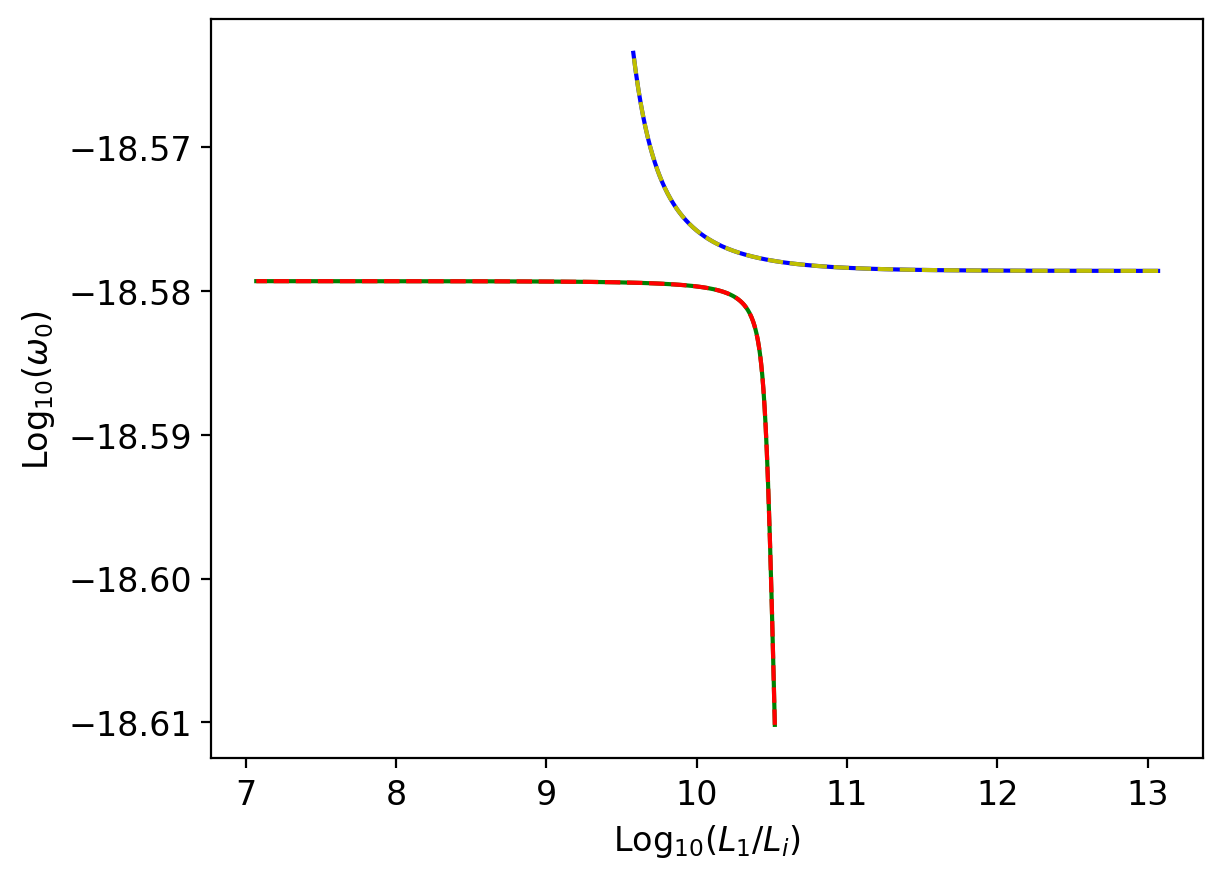

In [23]:
plt.plot(np.log10(vec_L_1[1]/np.real(L_i)), np.log10(omega_0*arr_omega_opt[:,1]), 'b')
plt.plot(np.log10(vec_L_1[0]/np.real(L_i)), np.log10(omega_0*arr_omega_opt[:,0]), 'g')
plt.plot(np.log10(vec_L_1_branch_up/np.real(L_i)), np.log10(vec_omega_branch_up), 'y', ls='dashed')
plt.plot(np.log10(vec_L_1_branch_down/np.real(L_i)), np.log10(vec_omega_branch_down), 'r', ls='dashed')
plt.xlabel("Log$_{10}(L_1/L_i)$")
plt.ylabel("Log$_{10}(\omega_0)$")

Text(0, 0.5, 'Log$_{10}(L_2/L_i)$')

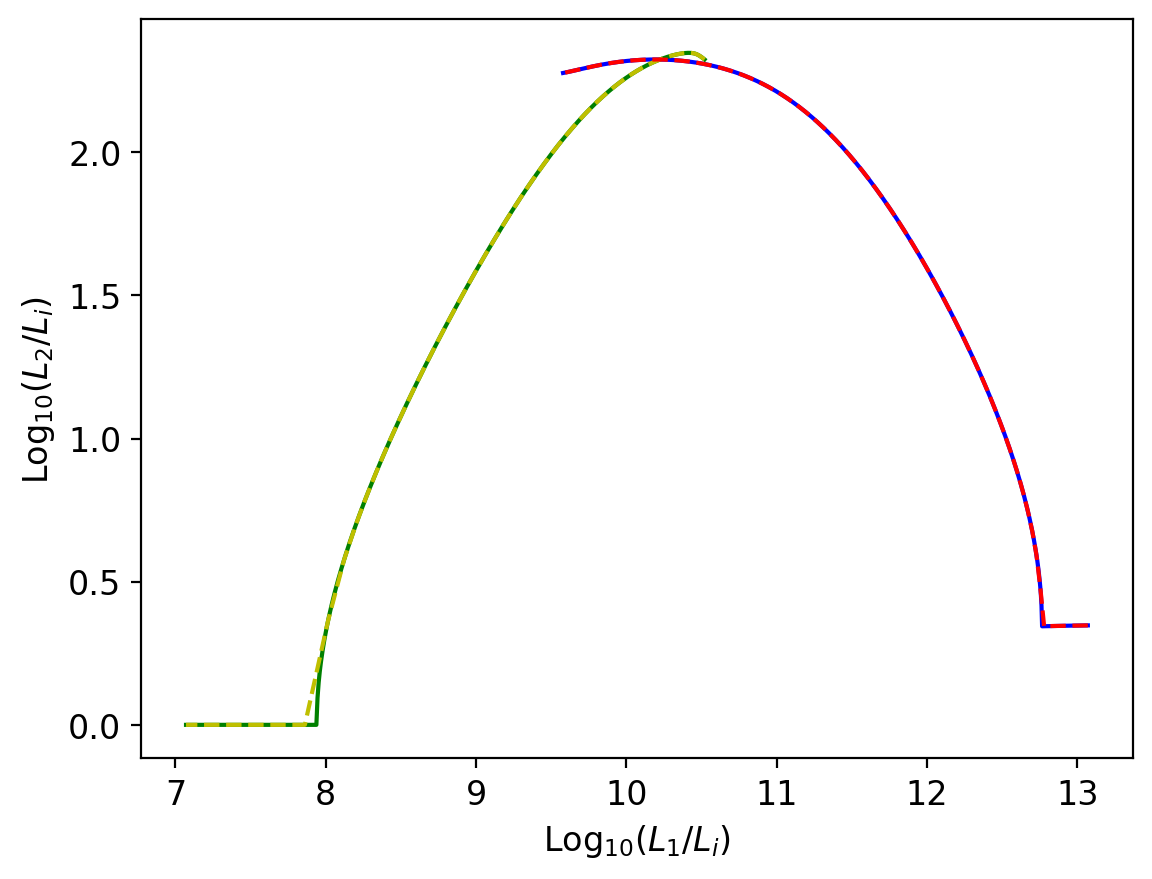

In [25]:
plt.plot(np.log10(vec_L_1[1]/np.real(L_i)), (np.log10(vec_L_2[:,1]/np.real(L_i))), 'b')
plt.plot(np.log10(vec_L_1[0]/np.real(L_i)), (np.log10(vec_L_2[:,0]/np.real(L_i))), 'g')
plt.plot(np.log10(vec_L_1_branch_down/np.real(L_i)), np.log10(vec_L_2_branch_down/np.real(L_i)), 'y', ls='dashed')
plt.plot(np.log10(vec_L_1_branch_up/np.real(L_i)), np.log10(vec_L_2_branch_up/np.real(L_i)), 'r', ls='dashed')
plt.xlabel("Log$_{10}(L_1/L_i)$")
plt.ylabel("Log$_{10}(L_2/L_i)$")

In [11]:
vec_theta_sens_plot = np.zeros(vec_omega_plot.shape)
for i,L_1 in enumerate(tqdm(vec_L_1_branch)):
    L_1_n = L_1 * (1 - 1j * eps_L_1)
    L_2 = vec_L_2_branch[i]
    if i < N_shots//2:
        C_1 = vec_C_1[0]
    else:
        C_1 = vec_C_1[1]
    vec_theta_sens_shot = fn_theta_sens(t_shot,Q_a,T,vec_omega_plot,l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid,L_i, k_i,C_1,L_1_n,L_2,k_f,eta, S_flux_squid,
                                        T_2,mu_N,n_N,xi_11,zeta_11,P_nuc,N_series,N_parallel)
    if vec_theta_sens_shot.all() > 0:
        vec_theta_sens_plot += vec_theta_sens_shot**(-4)
    else:
        print(L_2, C_1, L_1, end='')
vec_theta_sens_plot = vec_theta_sens_plot**(-1/4)

100%|██████████| 100000/100000 [01:43<00:00, 966.84it/s]


In [ ]:
omega = (omega_res + omega_0)/2
L_1_n = fn_L_1_down(omega) * (1 - 1j * eps_L_1)
C_1 = vec_C_1[0]
L_2 = L2_find(T, l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1_n, k_f, eta, S_flux_squid, T_2, mu_N, n_N, xi_11, zeta_11, P_nuc, N_series,N_parallel,0, np.real(L_i))[0]
vec_theta_sens_shot = fn_theta_sens(t_shot,Q_a,T,vec_omega_plot,l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid,L_i, k_i,C_1,L_1_n,L_2,k_f,eta, S_flux_squid,
                                    T_2,mu_N,n_N,xi_11,zeta_11,P_nuc,N_series,N_parallel)

In [14]:
np.save(dir_data+'omegafid.npy', [omega_res,omega_0])
np.save(dir_data+'vec_omega_plot.npy', vec_omega_plot)
np.save(dir_data+'vec_theta_shot.npy', vec_theta_sens_shot)
np.save(dir_data+'vec_theta_sens_plot.npy', vec_theta_sens_plot)

In [4]:
omega_res = np.load(dir_data+'omegafid.npy')[0]
omega_0 = np.load(dir_data+'omegafid.npy')[1]
vec_omega_plot = np.load(dir_data+'vec_omega_plot.npy')
vec_theta_sens_shot = np.load(dir_data+'vec_theta_shot.npy')
vec_theta_sens_plot = np.load(dir_data+'vec_theta_sens_plot.npy')

In [5]:
vec_G_aee_sens_shot = vec_theta_sens_shot / ThetaAxion * xi_11 / xi_11_G_aee
vec_G_aee_sens_plot = vec_theta_sens_plot / ThetaAxion * xi_11 / xi_11_G_aee

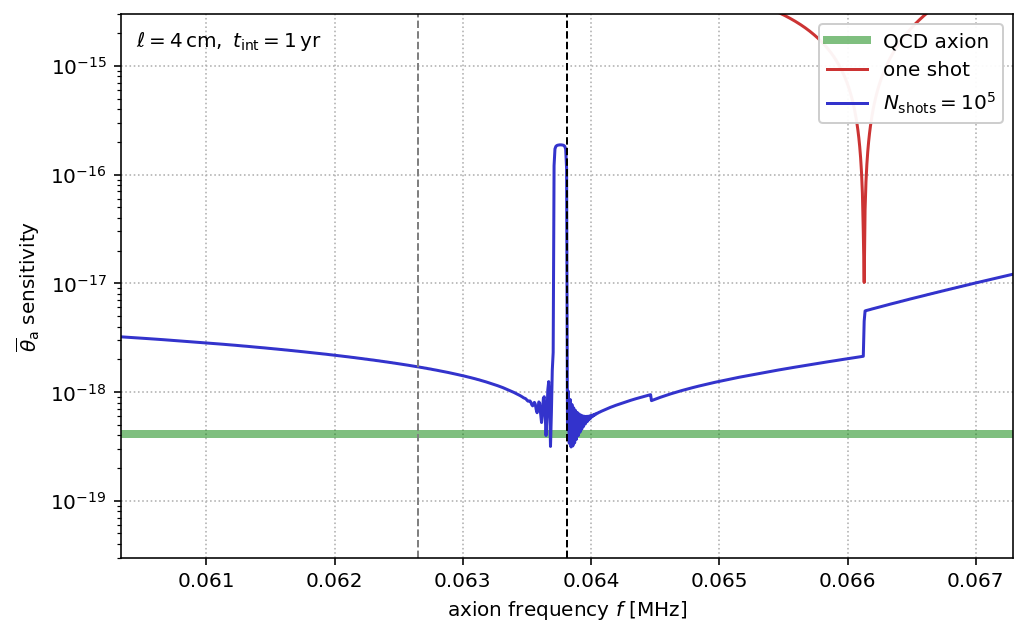

In [6]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot([1e-5,1e15],2*[ThetaAxion],color='green',lw=4,alpha=0.5,label='QCD axion')

ax.plot(vec_omega_plot/(2*np.pi*1e6*Second**-1),vec_theta_sens_shot,color=(0.8,0.2,0.2),label='one shot')
ax.plot(vec_omega_plot/(2*np.pi*1e6*Second**-1),vec_theta_sens_plot,color=(0.2,0.2,0.8),label='$N_\mathrm{shots} = 10^5$')
ax.axvline(omega_res/(2*np.pi*1e6*Second**-1),lw=1,ls='dashed',color='gray')
ax.axvline(omega_0/(2*np.pi*1e6*Second**-1),lw=1,ls='dashed',color='black')

#ax.plot(arr_comb[:,0]/(2*np.pi*Second**-1),arr_comb[:,1],lw=2,alpha=1,color='black',label='combined')
#for n in range(1,n_max+1):
    #ax.plot(arr[n-1,:,0]/(2*np.pi*Second**-1),arr[n-1,:,1],lw=1,alpha=0.8,label=r'$n = $'+str(n));
    #ax.axvline(0.95 * fn_omega_res(l,v,h_11,c_11,beta_11) /(2*np.pi*Second**-1),color='gray',ls='dashed',lw=1) #anti-resonances
    #ax.axvline(fn_omega_res(l,v,h_11,c_11,beta_11) /(2*np.pi*Second**-1),color='gray',ls='dashed',lw=1) #destructive interference
    
ax.set_xscale('linear'); ax.set_yscale('log');
xlim = vec_omega_plot[0]/(2*np.pi*1e6*Second**-1),vec_omega_plot[-1]/(2*np.pi*1e6*Second**-1)
ylim = 3e-20,3e-15
ax.set_xlim(xlim); ax.set_ylim(ylim);
ax.set_xlabel('axion frequency $f ~ [\mathrm{MHz}]$'); ax.set_ylabel(r'$\overline{\theta}_\mathrm{a}$ sensitivity');
ax.grid(ls='dotted');
ax.legend(loc='upper right',ncol=1,framealpha=0.95);
#ax.set_title(r'$\ell = 4\, \mathrm{cm},~t_\mathrm{int} = 1 \, \mathrm{yr}$');
ax.text(xlim[0]*(1.002),ylim[1]*0.5,r'$\ell = 4\, \mathrm{cm},~t_\mathrm{int} = 1 \, \mathrm{yr}$');

In [7]:
arr_comb_hypo_4cm_fund = np.transpose(np.asarray([vec_omega_plot,vec_theta_sens_plot]))

In [8]:
fig.savefig(dir_fig+'sensitivity_QCD_shot_4cm_eta20.pdf', bbox_inches='tight', pad_inches = 0)

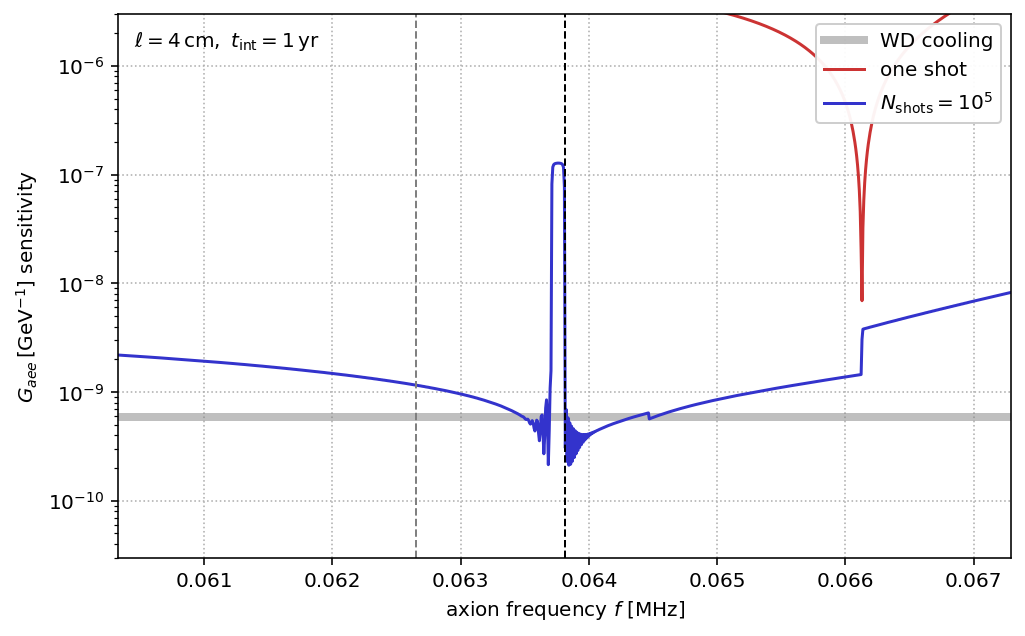

In [9]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot([1e-5,1e15],2*[3*1e-13/MElectron * GeV],color='gray',lw=4,alpha=0.5,label='WD cooling')

ax.plot(vec_omega_plot/(2*np.pi*1e6*Second**-1),vec_G_aee_sens_shot,color=(0.8,0.2,0.2),label='one shot')
ax.plot(vec_omega_plot/(2*np.pi*1e6*Second**-1),vec_G_aee_sens_plot,color=(0.2,0.2,0.8),label='$N_\mathrm{shots} = 10^5$')
ax.axvline(omega_res/(2*np.pi*1e6*Second**-1),lw=1,ls='dashed',color='gray')
ax.axvline(omega_0/(2*np.pi*1e6*Second**-1),lw=1,ls='dashed',color='black')

#ax.plot(arr_comb[:,0]/(2*np.pi*Second**-1),arr_comb[:,1],lw=2,alpha=1,color='black',label='combined')
#for n in range(1,n_max+1):
    #ax.plot(arr[n-1,:,0]/(2*np.pi*Second**-1),arr[n-1,:,1],lw=1,alpha=0.8,label=r'$n = $'+str(n));
    #ax.axvline(0.95 * fn_omega_res(l,v,h_11,c_11,beta_11) /(2*np.pi*Second**-1),color='gray',ls='dashed',lw=1) #anti-resonances
    #ax.axvline(fn_omega_res(l,v,h_11,c_11,beta_11) /(2*np.pi*Second**-1),color='gray',ls='dashed',lw=1) #destructive interference
    
ax.set_xscale('linear'); ax.set_yscale('log');
xlim = vec_omega_plot[0]/(2*np.pi*1e6*Second**-1),vec_omega_plot[-1]/(2*np.pi*1e6*Second**-1)
ylim = 3e-11,3e-6
ax.set_xlim(xlim); ax.set_ylim(ylim);
ax.set_xlabel('axion frequency $f ~ [\mathrm{MHz}]$'); ax.set_ylabel(r'$G_{aee} \, [\mathrm{GeV^{-1}}]$ sensitivity');
ax.grid(ls='dotted');
ax.legend(loc='upper right',ncol=1,framealpha=0.95);
#ax.set_title(r'$\ell = 4\, \mathrm{cm},~t_\mathrm{int} = 1 \, \mathrm{yr}$');
ax.text(xlim[0]*(1.002),ylim[1]*0.5,r'$\ell = 4\, \mathrm{cm},~t_\mathrm{int} = 1 \, \mathrm{yr}$');

## Xylophone (1 efold)

### 4cm

In [4]:
spacing = 3 * (1- omega_res/omega_0); spacing

0.054538287507915784

In [5]:
N_series = 1; N_parallel = 1; 
vec_l = 4*CentiMeter / (1+spacing)**np.arange(0.,np.log(2)/spacing,1.); 
t_int = 10 * Year
N_shots = int(1e3)
t_shot = t_int / N_shots / len(vec_l)
Q_a = (235 / np.sqrt(2) * KiloMeter / Second)**(-2);
print(vec_l / CentiMeter)

[4.         3.79312923 3.59695733 3.410931   3.23452552 3.06724332 2.90861257 2.75818584 2.61553883 2.48026919 2.35199539 2.23035562 2.11500677]


In [8]:
vec_omega_plot = np.logspace(np.log10((1-spacing)*np.abs(fn_omega_n(vec_l[0],v,1))),np.log10((1+spacing)*np.abs(fn_omega_n(vec_l[-1],v,1))),400)

In [6]:
def xylo_scan(l):
    vec_theta_sens_plot = np.zeros(vec_omega_plot.shape)
    omega_0 = np.abs(fn_omega_n(l,v,1)); 
    omega_res = fn_omega_res(l,v,h_11,c_11,beta_11);
    C_c = N_series**-1 * fn_C_crystal_TE_c(l,a,b,beta_11)
    C_1_fid = np.real(C_c)
    L_1_fid = 1/(omega_0**2 * np.real(C_c))
    L_2 = np.real(L_i)
    vec_L_1 = [L_1_fid * np.logspace(-2,1.47,int(1e3)), L_1_fid * np.logspace(0.30,4,int(1e3))]
    vec_C_1 = C_1_fid * np.asarray([0.1,30])
    vec_L_2 = np.ones((len(vec_L_1[0]),len(vec_C_1))) * np.nan;
    arr_omega_opt = np.ones((len(vec_L_1[0]),len(vec_C_1))) * np.nan; 
    for j,C_1 in enumerate(vec_C_1):
        for i,L_1 in enumerate(tqdm(vec_L_1[j])):
            L_1_n =  L_1 * (1 - 1j * eps_L_1)
            try:
                optimise = L2_find(T, l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1_n, k_f, eta, S_flux_squid, T_2, mu_N, n_N, xi_11, zeta_11, P_nuc, N_series,N_parallel,j, L_2)
                arr_omega_opt[i,j] = optimise[1]
                if optimise[1] > 0:
                    L_2 = optimise[0]
                    vec_L_2[i,j] = L_2
                else:
                    pass
            except ValueError:
                pass
    fn_L_1_down = interp1d(omega_0 * arr_omega_opt[np.isfinite(arr_omega_opt[:,0]),0],vec_L_1[0][np.isfinite(arr_omega_opt[:,0])],bounds_error=False,fill_value=np.nan)
    fn_L_1_up = interp1d(omega_0 * arr_omega_opt[np.isfinite(arr_omega_opt[:,1]),1],vec_L_1[1][np.isfinite(arr_omega_opt[:,1])],bounds_error=False,fill_value=np.nan)    
    fn_L_2_down = sp.interpolate.interp1d(omega_0 * arr_omega_opt[np.isfinite(arr_omega_opt[:,0]),0],vec_L_2[:,0][np.isfinite(arr_omega_opt[:,0])],bounds_error=False,fill_value=np.nan)
    fn_L_2_up = sp.interpolate.interp1d(omega_0 * arr_omega_opt[np.isfinite(arr_omega_opt[:,1]),1],vec_L_2[:,1][np.isfinite(arr_omega_opt[:,1])],bounds_error=False,fill_value=np.nan)
    vec_omega_branch_down = omega_0 * np.linspace(np.nanmin(arr_omega_opt[:,0]),np.nanmax(arr_omega_opt[:,0]),int(N_shots/2))
    vec_omega_branch_up = omega_0 * np.linspace(np.nanmin(arr_omega_opt[:,1]),np.nanmax(arr_omega_opt[:,1]),int(N_shots/2))
    vec_L_1_branch_down = fn_L_1_down(vec_omega_branch_down)
    vec_L_1_branch_up = fn_L_1_up(vec_omega_branch_up)
    vec_L_1_branch = np.concatenate([vec_L_1_branch_down,vec_L_1_branch_up])
    vec_L_2_branch_down = fn_L_2_down(vec_omega_branch_down)
    vec_L_2_branch_up = fn_L_2_up(vec_omega_branch_up)
    vec_L_2_branch = np.concatenate([vec_L_2_branch_down,vec_L_2_branch_up])
    for i,L_1 in enumerate(tqdm(vec_L_1_branch)):
        L_1_n = L_1 * (1 - 1j * eps_L_1)
        L_2 = vec_L_2_branch[i]
        if i < N_shots//2:
            C_1 = vec_C_1[0]
        else:
            C_1 = vec_C_1[1]
        vec_theta_sens_shot = fn_theta_sens(t_shot,Q_a,T,vec_omega_plot,l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid,L_i, k_i,C_1,L_1_n,L_2,k_f,eta, S_flux_squid,
                                            T_2,mu_N,n_N,xi_11,zeta_11,P_nuc,N_series,N_parallel)
        if vec_theta_sens_shot[0].all() > 0:
            vec_theta_sens_plot += vec_theta_sens_shot**(-4)
        else:
            print("L_2=",L_2, "C_1=",C_1, "L_1_n=",L_1,end='')
    return vec_theta_sens_plot


In [ ]:
ncores = len(vec_l)
pool = multiprocessing.Pool(ncores)

result = pool.map(xylo_scan, vec_l)
resultlist = list(result)
vec_theta_sens_plot = sum(resultlist)**(-1/4)

In [ ]:
#np.save(dir_data+'cmvec_omega_plot.npy', vec_omega_plot)
#np.save(dir_data+'cmvec_theta_sens_plot.npy', vec_theta_sens_plot)

In [10]:
vec_omega_plot = np.load(dir_data+'cmvec_omega_plot.npy')
vec_theta_sens_plot = np.load(dir_data+'cmvec_theta_sens_plot.npy')

In [11]:
vec_G_aee_sens_plot = vec_theta_sens_plot / ThetaAxion * xi_11 / xi_11_G_aee

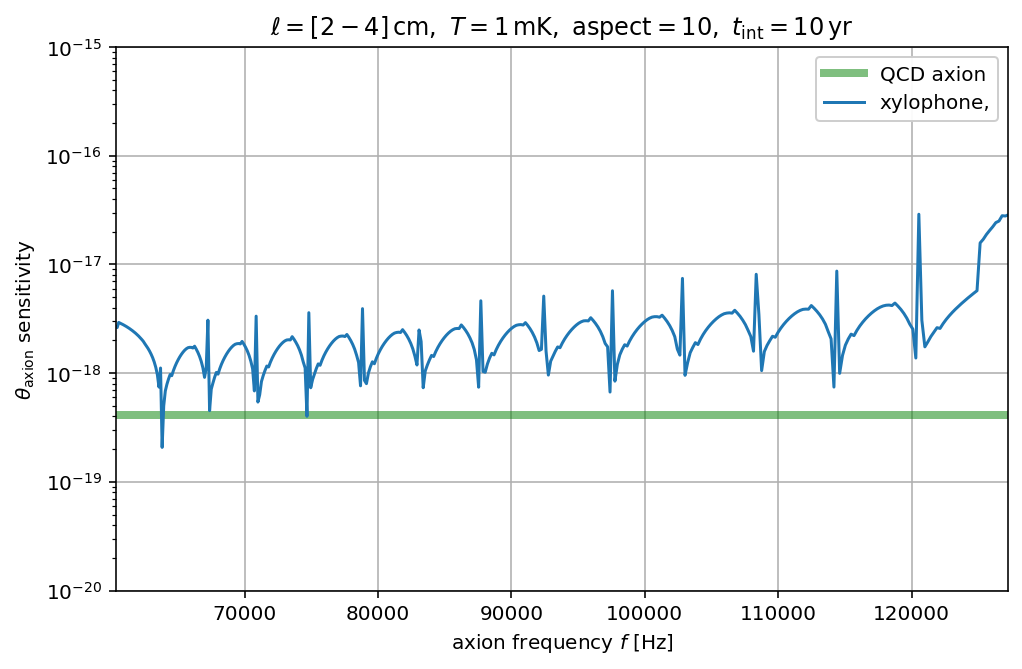

In [12]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot([1e-5,1e15],2*[ThetaAxion],color='green',lw=4,alpha=0.5,label='QCD axion')
ax.plot(vec_omega_plot/(2*np.pi*Second**-1),vec_theta_sens_plot,label='xylophone,')

ax.set_xscale('linear'); ax.set_yscale('log');
ax.set_xlim(vec_omega_plot[0]/(2*np.pi*Second**-1),vec_omega_plot[-1]/(2*np.pi*Second**-1)); ax.set_ylim(1e-20,1e-15);
ax.set_xlabel('axion frequency $f ~ [\mathrm{Hz}]$'); ax.set_ylabel(r'$\theta_\mathrm{axion}$ sensitivity');
ax.grid();
ax.legend(loc='upper right',ncol=1,framealpha=0.95);
ax.set_title(r'$\ell = [2-4]\, \mathrm{cm},~ T = 1\, \mathrm{mK}, ~\mathrm{aspect} = 10, ~t_\mathrm{int} = 10 \, \mathrm{yr}$');

In [13]:
arr_comb_hypo_4cm_xylo = np.transpose(np.asarray([vec_omega_plot,vec_theta_sens_plot]))
arr_comb_hypo_4cm_xylo_G_aee = np.transpose(np.asarray([vec_omega_plot,vec_G_aee_sens_plot]))

### 4mm

In [3]:
l = 0.4 * CentiMeter; N_series = 64; N_parallel = 4; 
omega_0 = np.abs(fn_omega_n(l,v,1)); 
omega_res = fn_omega_res(l,v,h_11,c_11,beta_11);

spacing = 3 * (1- omega_res/omega_0); spacing

0.054538287507915784

In [4]:
vec_l = 0.4*CentiMeter / (1+spacing)**np.arange(0.,np.log(2)/spacing,1.); 
t_int = 10 * Year
N_shots = int(1e5)
t_shot = t_int / N_shots / len(vec_l)
Q_a = (235 / np.sqrt(2) * KiloMeter / Second)**(-2);
print(vec_l / CentiMeter)

[0.4        0.37931292 0.35969573 0.3410931  0.32345255 0.30672433 0.29086126 0.27581858 0.26155388 0.24802692 0.23519954 0.22303556 0.21150068]


In [5]:
vec_omega_plot = np.logspace(np.log10((1-spacing)*np.abs(fn_omega_n(vec_l[0],v,1))),np.log10((1+spacing)*np.abs(fn_omega_n(vec_l[-1],v,1))),400)

In [ ]:
ncores = len(vec_l)
pool2 = multiprocessing.Pool(ncores)

result2 = pool2.map(xylo_scan, vec_l)
result2list = list(result2)
vec_theta_sens_plot = sum(result2list)**(-1/4)

In [ ]:
np.save(dir_data+'mmvec_omega_plot.npy', vec_omega_plot)
np.save(dir_data+'mmvec_theta_sens_plot.npy', vec_theta_sens_plot)

In [14]:
vec_omega_plot = np.load(dir_data+'mmvec_omega_plot.npy')
vec_theta_sens_plot = np.load(dir_data+'mmvec_theta_sens_plot.npy')

In [15]:
vec_G_aee_sens_plot = vec_theta_sens_plot / ThetaAxion * xi_11 / xi_11_G_aee

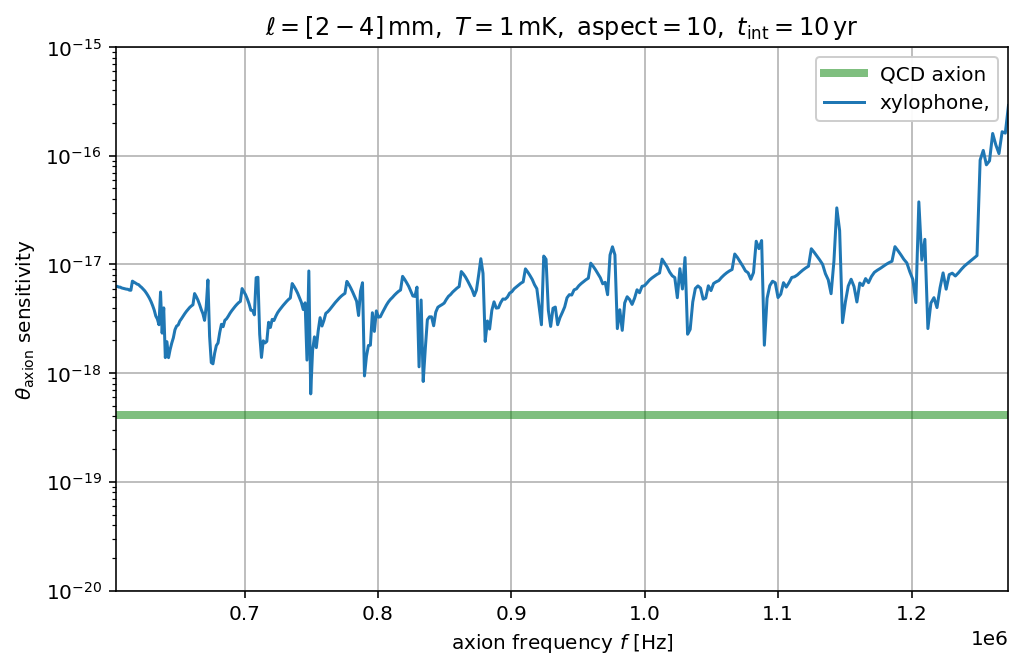

In [16]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot([1e-5,1e15],2*[ThetaAxion],color='green',lw=4,alpha=0.5,label='QCD axion')
ax.plot(vec_omega_plot/(2*np.pi*Second**-1),vec_theta_sens_plot,label='xylophone,')

ax.set_xscale('linear'); ax.set_yscale('log');
ax.set_xlim(vec_omega_plot[0]/(2*np.pi*Second**-1),vec_omega_plot[-1]/(2*np.pi*Second**-1)); ax.set_ylim(1e-20,1e-15);
ax.set_xlabel('axion frequency $f ~ [\mathrm{Hz}]$'); ax.set_ylabel(r'$\theta_\mathrm{axion}$ sensitivity');
ax.grid();
ax.legend(loc='upper right',ncol=1,framealpha=0.95);
ax.set_title(r'$\ell = [2-4]\, \mathrm{mm},~ T = 1\, \mathrm{mK}, ~\mathrm{aspect} = 10, ~t_\mathrm{int} = 10 \, \mathrm{yr}$');

In [17]:
arr_comb_hypo_4mm_xylo = np.transpose(np.asarray([vec_omega_plot,vec_theta_sens_plot]))
arr_comb_hypo_4mm_xylo_G_aee = np.transpose(np.asarray([vec_omega_plot,vec_G_aee_sens_plot]))

## Test of ultimate sensitivity (eta = 20)

In [18]:
vec_l = np.asarray([40.*CentiMeter,4.*CentiMeter,0.40*CentiMeter,0.04*CentiMeter,0.01*CentiMeter])
vec_aspect = np.asarray([np.sqrt(0.1),10,20,100,100])
vec_N_series = np.asarray([1,1,128,1024,4096])
vec_N_parallel = np.asarray([1,1,1,4,8])
vec_M = rho * vec_l**3 * vec_aspect**2 * vec_N_series * vec_N_parallel
print('masses =',vec_M/Kg, 'kilograms')
print([int(i) for i in vec_N_series*vec_N_parallel])

masses = [76.8     76.8     39.3216  31.45728  3.93216] kilograms
[1, 1, 128, 4096, 32768]


In [19]:
t_int = 10 * Year #scanning time per octave
N_shots = int(1e5) #number of shots per octave
t_shot = t_int / N_shots 
Q_a = (235 / np.sqrt(2) * KiloMeter / Second)**(-2);

In [20]:
i_l = 1
l = vec_l[i_l]
aspect = vec_aspect[i_l]; a = aspect; b = aspect; 
N_series = float(vec_N_series[i_l])
N_parallel = float(vec_N_parallel[i_l])
omega_0 = np.abs(fn_omega_n(l,v,1));
omega_res = fn_omega_res(l,v,h_11,c_11,beta_11);
C_c = N_series**(-1) * N_parallel * fn_C_crystal_TE_c(l,a,b,beta_11)
L_1_fid = 1/(omega_0**2 * np.real(C_c))
C_1_fid = np.real(C_c)
C_1 = 0.1*C_1_fid;
L_1 = 0.01*L_1_fid * (1 - 1j * eps_L_1);
L_2 = L2_find(T, l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1, k_f, eta, S_flux_squid, T_2, mu_N, n_N, xi_11, zeta_11, P_nuc, N_series,N_parallel,0, np.real(L_i))[0]
C_1_q = 0.1*C_1_fid;
L_1_q = 0.01*L_1_fid * (1 - 1j * eps_L_1);
L_2_q = np.real(L_i)

def fun_Z(omega_frac):
    return np.imag(fn_Z_total(omega_frac * omega_0,l,v,a,b,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1, L_2, k_f, N_series,N_parallel))
def fun_Z_q(omega_frac):
    return np.imag(fn_Z_total(omega_frac * omega_0,l,v,a,b,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1_q, L_1_q, L_2_q, k_f, N_series,N_parallel))
def fun_S(omega_frac):
    return fn_S_theta(T,omega_frac * omega_0,l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1, L_2, k_f, eta,  S_flux_squid,
                      T_2, mu_N, n_N, xi_11, zeta_11, P_nuc, N_series,N_parallel)
def fun_S_q(omega_frac):
    return fn_S_theta(T,omega_frac * omega_0,l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1_q, L_1_q, L_2_q, k_f, 1,  S_flux_squid,
                      T_2, mu_N, n_N, xi_11, zeta_11, P_nuc, N_series,N_parallel)
def fun_S_bandwidth(omega_frac,omega_opt):
    return fun_S(omega_frac)/fun_S(omega_opt)-4
def fun_S_bandwidth_q(omega_frac,omega_opt):
    return fun_S_q(omega_frac)/fun_S_q(omega_opt)-4
omega_frac = brentq(f=fun_Z,a=(2*omega_res-omega_0)/omega_0,b=(1-1e-5),xtol=1e-15)
omega_frac_1 = brentq(f=fun_S_bandwidth,a=omega_frac*(1-1e-1),b=omega_frac,xtol=1e-15,args=(omega_frac))
omega_frac_2 = brentq(f=fun_S_bandwidth,a=omega_frac,b=omega_frac*(1+1e-1),xtol=1e-15,args=(omega_frac))
omega_frac_q = brentq(f=fun_Z_q,a=(2*omega_res-omega_0)/omega_0,b=(1-1e-10),xtol=1e-15)
omega_frac_1_q = brentq(f=fun_S_bandwidth_q,a=omega_frac_q*(1-1e-1),b=omega_frac_q,xtol=1e-15,args=(omega_frac_q))
omega_frac_2_q = brentq(f=fun_S_bandwidth_q,a=omega_frac_q,b=omega_frac_q*(1+1e-1),xtol=1e-15,args=(omega_frac_q))

(0.9983585792248996, 0.9983586331779085)

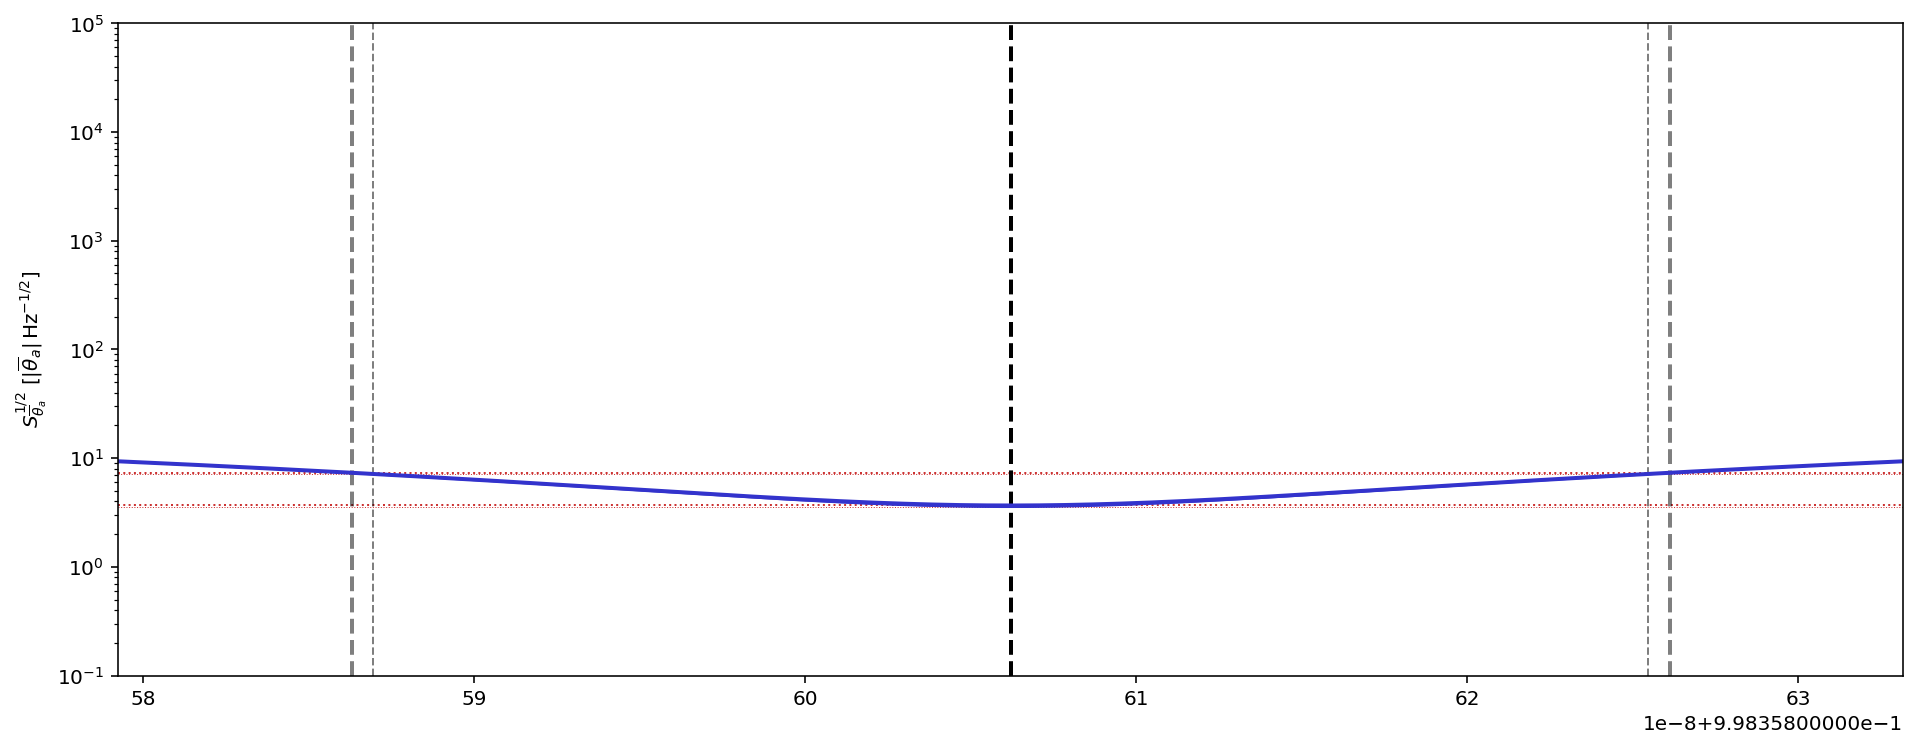

In [21]:
vec_omega_frac = np.linspace(omega_frac_1_q - 0.2*(omega_frac_2_q - omega_frac_1_q),omega_frac_2_q + 0.2*(omega_frac_2_q - omega_frac_1_q),int(1e4))
fig,ax = plt.subplots(1,1,figsize=(16,6))
ax.axhline(np.sqrt(fun_S(omega_frac))/(ThetaAxion/np.sqrt(Hz)),color=(0.8,0.2,0.2),lw=1,ls='dotted')
ax.axhline(2*np.sqrt(fun_S(omega_frac))/(ThetaAxion/np.sqrt(Hz)),color=(0.8,0.2,0.2),lw=1,ls='dotted')
ax.axhline(np.sqrt(fun_S_q(omega_frac))/(ThetaAxion/np.sqrt(Hz)),color=(0.8,0.2,0.2),lw=0.5,ls='dotted')
ax.axhline(2*np.sqrt(fun_S_q(omega_frac))/(ThetaAxion/np.sqrt(Hz)),color=(0.8,0.2,0.2),lw=0.5,ls='dotted')
ax.axvline(omega_frac,color=(0,0,0),lw=2,ls='dashed')
ax.axvline(omega_frac_1,color=(0,0,0,0.5),lw=2,ls='dashed')
ax.axvline(omega_frac_2,color=(0,0,0,0.5),lw=2,ls='dashed')
ax.axvline(omega_frac_1_q,color=(0,0,0,0.5),lw=1,ls='dashed')
ax.axvline(omega_frac_2_q,color=(0,0,0,0.5),lw=1,ls='dashed')

ax.plot(vec_omega_frac,np.sqrt(fun_S(vec_omega_frac))/(ThetaAxion/np.sqrt(Hz)),color=(0.2,0.2,0.8),lw=2)
ax.plot(vec_omega_frac,np.sqrt(fun_S_q(vec_omega_frac))/(ThetaAxion/np.sqrt(Hz)),color=(0.2,0.2,0.8),lw=1)
ax.set_yscale('log');
ax.set_ylim(1e-1,1e5);
ax.set_ylabel(r'$S^{1/2}_{\overline{\theta}_a} ~ [|\overline{\theta}_a| \, \mathrm{Hz}^{-1/2}]$');
ax.set_xlim(vec_omega_frac[0],vec_omega_frac[-1])

(0.9983586040870613, 0.9983586083157185)

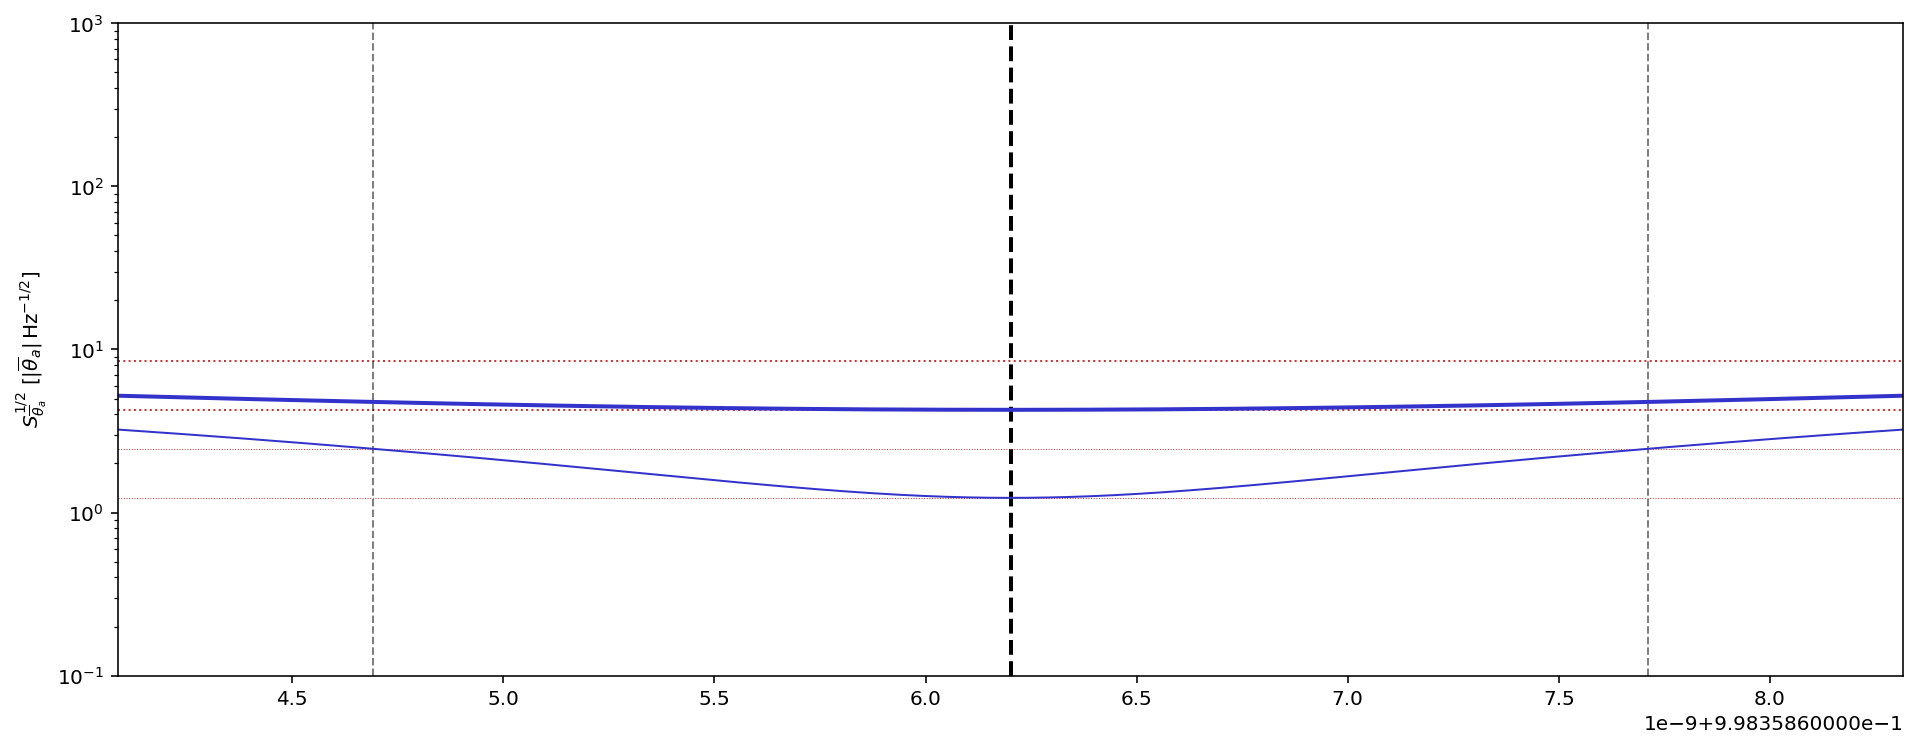

In [22]:
i_l = 4
l = vec_l[i_l]
aspect = vec_aspect[i_l]; a = aspect; b = aspect; 
N_series = float(vec_N_series[i_l])
N_parallel = float(vec_N_parallel[i_l])
omega_0 = np.abs(fn_omega_n(l,v,1));
omega_res = fn_omega_res(l,v,h_11,c_11,beta_11);
C_c = N_series**(-1) * N_parallel * fn_C_crystal_TE_c(l,a,b,beta_11)
L_1_fid = 1/(omega_0**2 * np.real(C_c))
C_1_fid = np.real(C_c)
C_1 = 0.1*C_1_fid;
L_1 = 0.01*L_1_fid * (1 - 1j * eps_L_1);
L_2 = np.real(L_i)
def fun_Z(omega_frac):
    return np.imag(fn_Z_total(omega_frac * omega_0,l,v,a,b,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1, L_2, k_f, N_series,N_parallel))
def fun_S(omega_frac):
    return fn_S_theta(T,omega_frac * omega_0,l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1, L_2, k_f, eta, S_flux_squid,
                      T_2, mu_N, n_N, xi_11, zeta_11, P_nuc, N_series,N_parallel)
def fun_S_q(omega_frac):
    return fn_S_theta(T,omega_frac * omega_0,l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1, L_2, k_f, 1, S_flux_squid,
                      T_2, mu_N, n_N, xi_11, zeta_11, P_nuc, N_series,N_parallel)
def fun_S_bandwidth(omega_frac,omega_opt):
    return fun_S(omega_frac)/fun_S(omega_opt)-4
def fun_S_bandwidth_q(omega_frac,omega_opt):
    return fun_S_q(omega_frac)/fun_S_q(omega_opt)-4
omega_frac = brentq(f=fun_Z,a=(2*omega_res-omega_0)/omega_0,b=(1-1e-10),xtol=1e-15)
omega_frac_1 = brentq(f=fun_S_bandwidth,a=omega_frac*(1-1e-1),b=omega_frac,xtol=1e-15,args=(omega_frac))
omega_frac_2 = brentq(f=fun_S_bandwidth,a=omega_frac,b=omega_frac*(1+1e-1),xtol=1e-15,args=(omega_frac))
omega_frac_1_q = brentq(f=fun_S_bandwidth_q,a=omega_frac*(1-1e-1),b=omega_frac,xtol=1e-15,args=(omega_frac))
omega_frac_2_q = brentq(f=fun_S_bandwidth_q,a=omega_frac,b=omega_frac*(1+1e-1),xtol=1e-15,args=(omega_frac))
vec_omega_frac = np.linspace(omega_frac_1_q - 0.2*(omega_frac_2_q - omega_frac_1_q),omega_frac_2_q + 0.2*(omega_frac_2_q - omega_frac_1_q),int(1e4))
fig,ax = plt.subplots(1,1,figsize=(16,6))
ax.axhline(np.sqrt(fun_S(omega_frac))/(ThetaAxion/np.sqrt(Hz)),color=(0.8,0.2,0.2),lw=1,ls='dotted')
ax.axhline(2*np.sqrt(fun_S(omega_frac))/(ThetaAxion/np.sqrt(Hz)),color=(0.8,0.2,0.2),lw=1,ls='dotted')
ax.axhline(np.sqrt(fun_S_q(omega_frac))/(ThetaAxion/np.sqrt(Hz)),color=(0.8,0.2,0.2),lw=0.5,ls='dotted')
ax.axhline(2*np.sqrt(fun_S_q(omega_frac))/(ThetaAxion/np.sqrt(Hz)),color=(0.8,0.2,0.2),lw=0.5,ls='dotted')
ax.axvline(omega_frac,color=(0,0,0),lw=2,ls='dashed')
ax.axvline(omega_frac_1,color=(0,0,0,0.5),lw=2,ls='dashed')
ax.axvline(omega_frac_2,color=(0,0,0,0.5),lw=2,ls='dashed')
ax.axvline(omega_frac_1_q,color=(0,0,0,0.5),lw=1,ls='dashed')
ax.axvline(omega_frac_2_q,color=(0,0,0,0.5),lw=1,ls='dashed')

ax.plot(vec_omega_frac,np.sqrt(fun_S(vec_omega_frac))/(ThetaAxion/np.sqrt(Hz)),color=(0.2,0.2,0.8),lw=2)
ax.plot(vec_omega_frac,np.sqrt(fun_S_q(vec_omega_frac))/(ThetaAxion/np.sqrt(Hz)),color=(0.2,0.2,0.8),lw=1)
ax.set_yscale('log');
ax.set_ylim(1e-1,1e3);
ax.set_ylabel(r'$S^{1/2}_{\overline{\theta}_a} ~ [|\overline{\theta}_a| \, \mathrm{Hz}^{-1/2}]$');
ax.set_xlim(vec_omega_frac[0],vec_omega_frac[-1])

(0.9983586040870613, 0.9983586083157185)

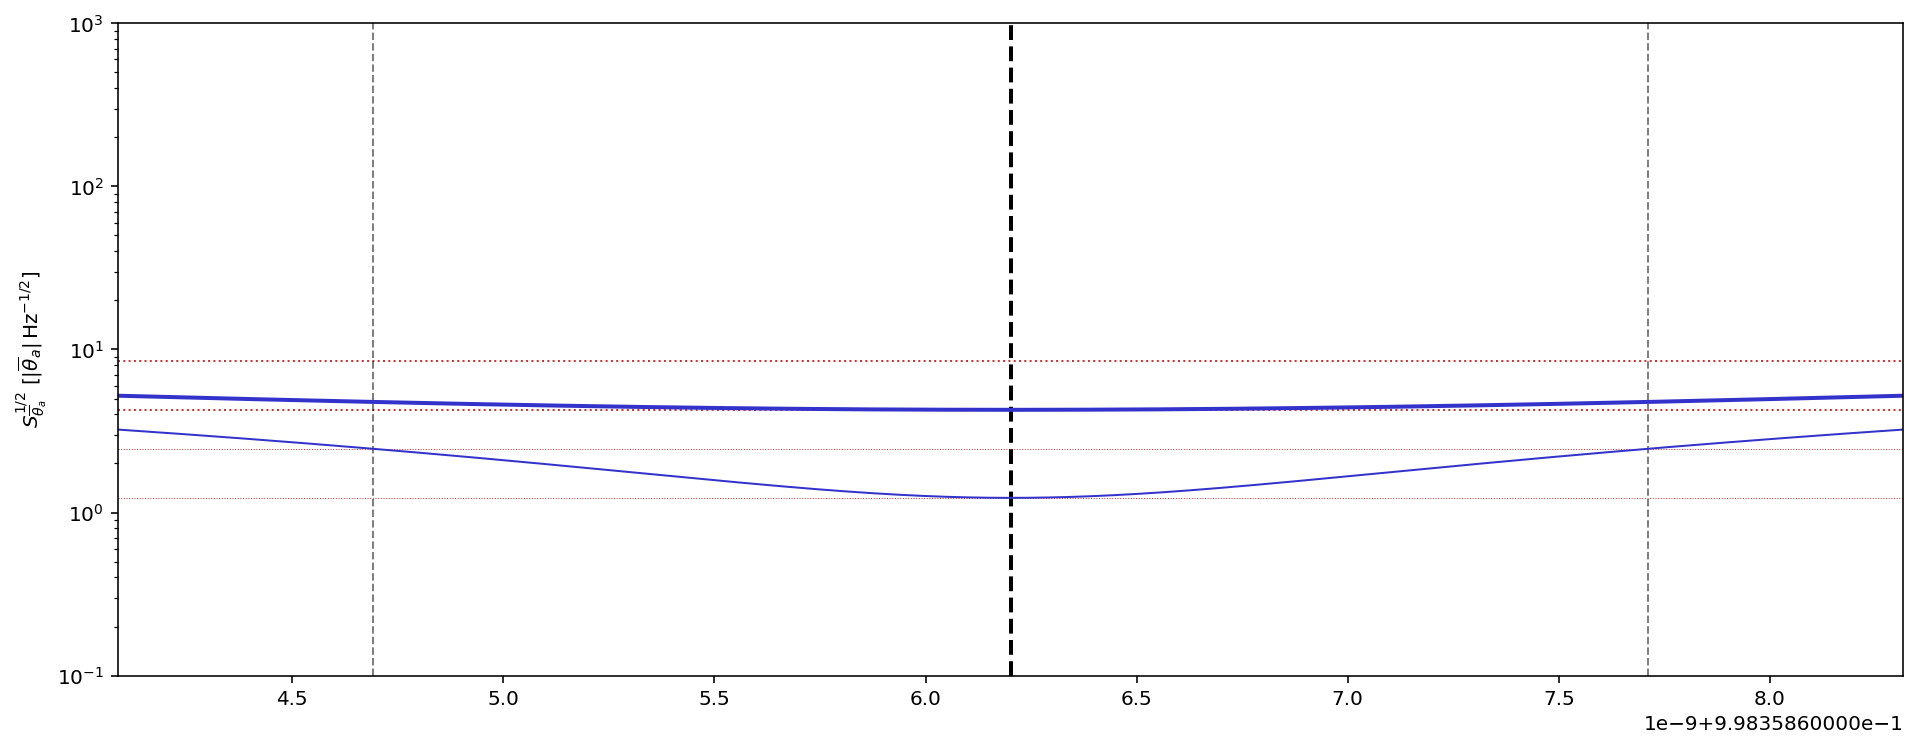

In [23]:
vec_omega_frac = np.linspace(omega_frac_1_q - 0.2*(omega_frac_2_q - omega_frac_1_q),omega_frac_2_q + 0.2*(omega_frac_2_q - omega_frac_1_q),int(1e4))
fig,ax = plt.subplots(1,1,figsize=(16,6))
ax.axhline(np.sqrt(fun_S(omega_frac))/(ThetaAxion/np.sqrt(Hz)),color=(0.8,0.2,0.2),lw=1,ls='dotted')
ax.axhline(2*np.sqrt(fun_S(omega_frac))/(ThetaAxion/np.sqrt(Hz)),color=(0.8,0.2,0.2),lw=1,ls='dotted')
ax.axhline(np.sqrt(fun_S_q(omega_frac))/(ThetaAxion/np.sqrt(Hz)),color=(0.8,0.2,0.2),lw=0.5,ls='dotted')
ax.axhline(2*np.sqrt(fun_S_q(omega_frac))/(ThetaAxion/np.sqrt(Hz)),color=(0.8,0.2,0.2),lw=0.5,ls='dotted')
ax.axvline(omega_frac,color=(0,0,0),lw=2,ls='dashed')
ax.axvline(omega_frac_1,color=(0,0,0,0.5),lw=2,ls='dashed')
ax.axvline(omega_frac_2,color=(0,0,0,0.5),lw=2,ls='dashed')
ax.axvline(omega_frac_1_q,color=(0,0,0,0.5),lw=1,ls='dashed')
ax.axvline(omega_frac_2_q,color=(0,0,0,0.5),lw=1,ls='dashed')

ax.plot(vec_omega_frac,np.sqrt(fun_S(vec_omega_frac))/(ThetaAxion/np.sqrt(Hz)),color=(0.2,0.2,0.8),lw=2)
ax.plot(vec_omega_frac,np.sqrt(fun_S_q(vec_omega_frac))/(ThetaAxion/np.sqrt(Hz)),color=(0.2,0.2,0.8),lw=1)
ax.set_yscale('log');
ax.set_ylim(1e-1,1e3);
ax.set_ylabel(r'$S^{1/2}_{\overline{\theta}_a} ~ [|\overline{\theta}_a| \, \mathrm{Hz}^{-1/2}]$');
ax.set_xlim(vec_omega_frac[0],vec_omega_frac[-1])

## Ultimate (eta = 20)

In [24]:
vec_l = np.asarray([40.*CentiMeter,4.*CentiMeter,0.40*CentiMeter,0.04*CentiMeter,0.01*CentiMeter])
vec_aspect = np.asarray([np.sqrt(0.1),10,20,100,100])
vec_N_series = np.asarray([1,1,128,1024,4096])
vec_N_parallel = np.asarray([1,1,1,4,8])
vec_M = rho * vec_l**3 * vec_aspect**2 * vec_N_series * vec_N_parallel
print('masses =',vec_M/Kg, 'kilograms')
print([int(i) for i in vec_N_series*vec_N_parallel])

masses = [76.8     76.8     39.3216  31.45728  3.93216] kilograms
[1, 1, 128, 4096, 32768]


In [25]:
t_int = 10 * Year #scanning time per octave
N_shots = int(1e5) #number of shots per octave
t_shot = t_int / N_shots 
Q_a = (235 / np.sqrt(2) * KiloMeter / Second)**(-2);

In [26]:
vec_omega_opt = np.zeros(len(vec_l))
vec_band_frac = np.zeros(len(vec_l))
vec_S_opt = np.zeros(len(vec_l))
vec_theta_sens_piezo = np.zeros(len(vec_l))
vec_theta_sens_electro = np.zeros(len(vec_l))

for i_l,l in enumerate(vec_l):
    aspect = vec_aspect[i_l]; a = aspect; b = aspect; 
    N_series = float(vec_N_series[i_l])
    N_parallel = float(vec_N_parallel[i_l])
    omega_0 = np.abs(fn_omega_n(l,v,1));
    omega_res = fn_omega_res(l,v,h_11,c_11,beta_11);
    C_c = N_series**(-1) * N_parallel * fn_C_crystal_TE_c(l,a,b,beta_11)
    L_1_fid = 1/(omega_0**2 * np.real(C_c))
    C_1_fid = np.real(C_c)
    C_1 = 0.1*C_1_fid;
    L_1 = 0.01*L_1_fid * (1 - 1j * eps_L_1);
    L_2 = L2_find(T, l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1, k_f, eta, S_flux_squid, T_2, mu_N, n_N, xi_11, zeta_11, P_nuc, N_series,N_parallel,0, 10*np.real(L_i))[0]
    def fun_Z(omega_frac):
        return np.imag(fn_Z_total(omega_frac * omega_0,l,v,a,b,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1, L_2, k_f, N_series,N_parallel))
    def fun_S(omega_frac):
        return fn_S_theta(T,omega_frac * omega_0,l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1, L_2, k_f, eta, S_flux_squid,
                          T_2, mu_N, n_N, xi_11, zeta_11, P_nuc, N_series,N_parallel)
    def fun_S_bandwidth(omega_frac,omega_opt):
        return fun_S(omega_frac)/fun_S(omega_opt)-4
    try:
        omega_frac = brentq(f=fun_Z,a=(2*omega_res-omega_0)/omega_0,b=(1-1e-10),xtol=1e-15)
        vec_omega_opt[i_l] = omega_0 * omega_frac
        vec_S_opt[i_l] = fun_S(omega_frac)
        omega_frac_1 = brentq(f=fun_S_bandwidth,a=omega_frac*(1-1e-1),b=omega_frac,xtol=1e-15,args=(omega_frac))
        omega_frac_2 = brentq(f=fun_S_bandwidth,a=omega_frac,b=omega_frac*(1+1e-1),xtol=1e-15,args=(omega_frac))
        vec_band_frac[i_l] = (omega_frac_2 - omega_frac_1)/omega_frac
        t_shot = t_int / np.log(2) * vec_band_frac[i_l]
        vec_theta_sens_piezo[i_l] = fn_theta_sens(t_shot, Q_a, T, vec_omega_opt[i_l],l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1, L_2, k_f, eta, S_flux_squid, T_2, mu_N, n_N, xi_11, zeta_11, P_nuc, N_series, N_parallel)
        vec_theta_sens_electro[i_l] = fn_theta_sens(t_shot,Q_a,T,vec_omega_opt[i_l],l,v,a,b,h_11,c_11,beta_11,k2,L_squid,R_squid,L_i, k_i,C_1,L_1,L_2,k_f,eta,  S_flux_squid,
                                                    T_2,mu_N,n_N,0*xi_11,zeta_11,P_nuc,N_series,N_parallel)

    except ValueError:
        print('err')
        pass
    #print('[l/cm, mass/kg, C_1/picoFarad, L_1/milliHenry, omega_frac] =', 
    #[str(l/CentiMeter)[0:6], str(vec_M[i_l]/Kg)[0:6], str(C_1/(1e-12*Farad))[0:6],str(L_1/(1e-3*Henry))[0:6])

In [27]:
vec_G_aee_sens_piezo = vec_theta_sens_piezo / ThetaAxion * xi_11 / xi_11_G_aee
vec_G_aee_sens_electro = vec_theta_sens_electro / ThetaAxion * xi_11 / xi_11_G_aee

In [28]:
print(np.sqrt(vec_S_opt[:]/(ThetaAxion**2 / Hz)) )
print(vec_theta_sens_piezo/ThetaAxion)
print(vec_theta_sens_electro/ThetaAxion)
print(vec_band_frac)
print(vec_omega_opt/(2*np.pi*1e3*Hz))

[11.24944877  3.66933002  1.94845168  1.37818025  6.85388853]
[ 0.86638277  0.66496909  0.83123148  1.56333148 11.35489875]
[ 72.29109222  55.48510807  69.36677787 130.47494908 947.68115291]
[1.22281918e-07 3.98857506e-08 1.29881481e-08 2.59834296e-09 2.28429271e-09]
[6.37079056e+00 6.37079056e+01 6.37079190e+02 6.37079303e+03 2.54831724e+04]


In [29]:
arr_sens_ultimate = np.transpose([vec_omega_opt,vec_theta_sens_piezo,vec_theta_sens_electro])
arr_sens_ultimate_G_aee = np.transpose([vec_omega_opt,vec_G_aee_sens_piezo,vec_G_aee_sens_electro])

## Ultimate (eta = 1)

In [30]:
vec_omega_opt_q = np.zeros(len(vec_l))
vec_band_frac_q = np.zeros(len(vec_l))
vec_S_opt_q = np.zeros(len(vec_l))
vec_theta_sens_piezo_q = np.zeros(len(vec_l))
vec_theta_sens_electro_q = np.zeros(len(vec_l))
L_2 = np.real(L_i)

for i_l,l in enumerate(vec_l):
    aspect = vec_aspect[i_l]; a = aspect; b = aspect; 
    N_series = float(vec_N_series[i_l])
    N_parallel = float(vec_N_parallel[i_l])
    omega_0 = np.abs(fn_omega_n(l,v,1));
    omega_res = fn_omega_res(l,v,h_11,c_11,beta_11);
    C_c = N_series**(-1) * N_parallel * fn_C_crystal_TE_c(l,a,b,beta_11)
    L_1_fid = 1/(omega_0**2 * np.real(C_c))
    C_1_fid = np.real(C_c)
    C_1 = 0.1*C_1_fid;
    L_1 = 0.01*L_1_fid * (1 - 1j * eps_L_1);
    #L_2 = L2_find(T, l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1, k_f, 1, S_flux_squid, T_2, mu_N, n_N, xi_11, zeta_11, P_nuc, N_series,N_parallel,0)[0]
    def fun_Z(omega_frac):
        return np.imag(fn_Z_total(omega_frac * omega_0,l,v,a,b,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1, L_2, k_f, N_series,N_parallel))
    def fun_S(omega_frac):
        return fn_S_theta(T,omega_frac * omega_0,l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1, L_2, k_f, 1,S_flux_squid,
                          T_2, mu_N, n_N, xi_11, zeta_11, P_nuc, N_series,N_parallel)
    def fun_S_bandwidth(omega_frac,omega_opt):
        return fun_S(omega_frac)/fun_S(omega_opt)-2
    try:
        omega_frac_q = brentq(f=fun_Z,a=(2*omega_res-omega_0)/omega_0,b=(1-1e-10),xtol=1e-15)
        vec_omega_opt_q[i_l] = omega_0 * omega_frac_q
        vec_S_opt_q[i_l] = fun_S(omega_frac_q)
        omega_frac_1_q = brentq(f=fun_S_bandwidth,a=omega_frac_q*(1-1e-1),b=omega_frac_q,xtol=1e-15,args=(omega_frac_q))
        omega_frac_2_q = brentq(f=fun_S_bandwidth,a=omega_frac_q,b=omega_frac_q*(1+1e-1),xtol=1e-15,args=(omega_frac_q))
        vec_band_frac_q[i_l] = (omega_frac_2_q - omega_frac_1_q)/omega_frac_q
        t_shot = t_int / np.log(2) * vec_band_frac_q[i_l]
        vec_theta_sens_piezo_q[i_l] = fn_theta_sens(t_shot,Q_a,T,vec_omega_opt_q[i_l],l,v,a,b,h_11,c_11,beta_11,k2,L_squid,R_squid,L_i, k_i,C_1,L_1,L_2,k_f,1,S_flux_squid, 
                                                  T_2,mu_N,n_N,xi_11,zeta_11,P_nuc,N_series,N_parallel)
        vec_theta_sens_electro_q[i_l] = fn_theta_sens(t_shot,Q_a,T,vec_omega_opt_q[i_l],l,v,a,b,h_11,c_11,beta_11,k2,L_squid,R_squid,L_i, k_i,C_1,L_1,L_2,k_f,1,S_flux_squid, 
                                                    T_2,mu_N,n_N,0*xi_11,zeta_11,P_nuc,N_series,N_parallel)

    except ValueError:
        print('err')
        pass
    #print('[l/cm, mass/kg, C_1/picoFarad, L_1/milliHenry, omega_frac] =', 
    #[str(l/CentiMeter)[0:6], str(vec_M[i_l]/Kg)[0:6], str(C_1/(1e-12*Farad))[0:6],str(L_1/(1e-3*Henry))[0:6])

In [31]:
vec_G_aee_sens_piezo_q = vec_theta_sens_piezo_q / ThetaAxion * xi_11 / xi_11_G_aee
vec_G_aee_sens_electro_q = vec_theta_sens_electro_q / ThetaAxion * xi_11 / xi_11_G_aee

In [32]:
print(np.sqrt(vec_S_opt_q[:]/(ThetaAxion**2 / Hz)) )
print(vec_theta_sens_piezo_q/ThetaAxion)
print(vec_theta_sens_electro_q/ThetaAxion)
print(vec_band_frac_q)
print(vec_omega_opt_q/(2*np.pi*1e3*Hz))

[11.21146031  3.55115861  1.59474498  0.64681629  1.23004757]
[0.9913983  0.74435324 0.78951652 0.73374011 2.17921065]
[ 82.7224045   62.1089324   65.87736187  61.22337135 181.83362229]
[7.03610896e-08 2.22864269e-08 7.16137798e-09 2.59795275e-09 1.74673602e-09]
[6.37079056e+00 6.37079056e+01 6.37079056e+02 6.37079056e+03 2.54831622e+04]


In [33]:
arr_sens_ultimate_q = np.transpose([vec_omega_opt_q,vec_theta_sens_piezo_q,vec_theta_sens_electro_q])
arr_sens_ultimate_G_aee_q = np.transpose([vec_omega_opt_q,vec_G_aee_sens_piezo_q,vec_G_aee_sens_electro_q])

## Combined

### Plot Prep

#### QCD axion

In [34]:
def fn_fa(ma):
    return 1e12 * GeV * (5.70e-6 * eV)/ma

In [35]:
vec_ma = eV * np.logspace(-14,-6,100)

#### Superradiance

In [36]:
df_SR = pd.read_csv(dir_data+'gluon_SR.csv',header=None,names=['ma [eV]','fa^-1 [GeV^-1]'])
df_SR_proj = pd.read_csv(dir_data+'gluon_SR_proj.csv',header=None,names=['ma [eV]','fa^-1 [GeV^-1]'])

#### Sun

In [37]:
df_sun = pd.read_csv(dir_data+'gluon_sun.csv',header=None,names=['ma [eV]','fa^-1 [GeV^-1]'])
int_sun_log = interp1d(np.log10(df_sun['ma [eV]']),np.log10(df_sun['fa^-1 [GeV^-1]']),bounds_error=False,fill_value='extrapolate')
def int_sun(m):
    return 10**int_sun_log(np.log10(m/eV))

#### White Dwarfs

In [38]:
df_wd = pd.read_csv(dir_data+'whitedwarfs.csv',header=None,names=['ma [eV]','fa^-1 [GeV^-1]'])
int_wd_log = interp1d(np.log10(df_wd['ma [eV]']),np.log10(df_wd['fa^-1 [GeV^-1]']),bounds_error=False,fill_value='extrapolate')
def int_wd(m):
    return 10**int_wd_log(np.log10(m/eV))

#### BBN

In [39]:
df_bbn = pd.read_csv(dir_data+'gluon_bbn.csv',header=None,names=['ma [eV]','fa^-1 [GeV^-1]'])
int_bbn_log = interp1d(np.log10(df_bbn['ma [eV]']),np.log10(df_bbn['fa^-1 [GeV^-1]']),bounds_error=False,fill_value='extrapolate')
def int_bbn(m):
    return 10**int_bbn_log(np.log10(m/eV))

#### GW

In [40]:
df_GW_high = pd.read_csv(dir_data+'gluon_GW_high.csv',header=None,names=['ma [eV]','fa^-1 [GeV^-1]'])
df_GW_low = pd.read_csv(dir_data+'gluon_GW_low.csv',header=None,names=['ma [eV]','fa^-1 [GeV^-1]'])
int_GW_high_log = interp1d(np.log10(df_GW_high['ma [eV]']),np.log10(df_GW_high['fa^-1 [GeV^-1]']),bounds_error=False,fill_value='extrapolate')
int_GW_low_log = interp1d(np.log10(df_GW_low['ma [eV]']),np.log10(df_GW_low['fa^-1 [GeV^-1]']),bounds_error=False,fill_value='extrapolate')
def int_GW_high(m):
    return 10**int_GW_high_log(np.log10(m/eV))
def int_GW_low(m):
    return 10**int_GW_low_log(np.log10(m/eV))

### Plot (nuclear coupling)

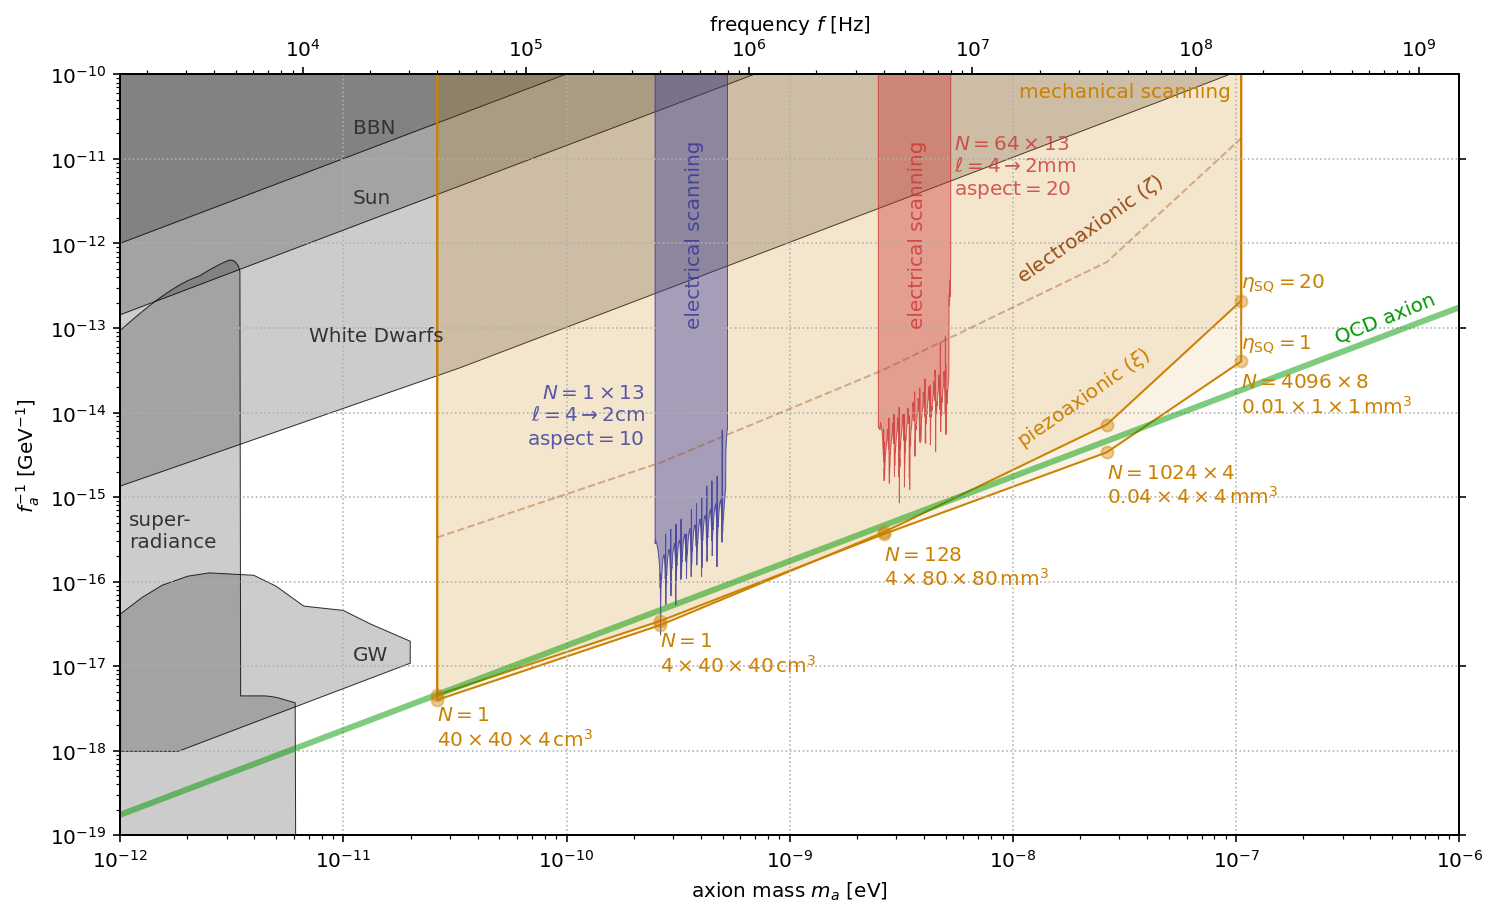

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlim(1e-12,1e-6); ax.set_ylim(1e-19,1e-10)
ax_top = ax.twiny();  ax_top.set_xlim(ax.get_xlim()); ax_top.set_xscale('log');
#ax_top2 = ax.twiny();  ax_top2.set_xlim(ax.get_xlim()); ax_top2.set_xscale('log');
#ax_top2.spines.top.set_position(("axes", 1.1))
ax_right = ax.twinx();  ax_right.set_ylim(ax.get_ylim()); ax_right.set_yscale('log');
ax_right.set_yticklabels([]);
ax.set_xlabel(r'axion mass $m_a~[\mathrm{eV}]$'); ax_top.set_xlabel('frequency $f~[\mathrm{Hz}]$'); ax.set_ylabel('$f_a^{-1}~[\mathrm{GeV}^{-1}]$')
ticks_left_minor = np.outer(10**(np.arange(-19.0,-5)),np.arange(1.,10.,1.)).flatten()
ticks_left_minor = ticks_left_minor[(ax.get_ylim()[0] < ticks_left_minor) & (ticks_left_minor < ax.get_ylim()[1])]
ticks_left_major = 10**(np.arange(-19.0,-9))
ticks_top_minor = np.outer(10**(np.arange(0.0,10)),np.arange(1.,10.,1.)).flatten() * Hz / eV; 
ticks_top_minor = ticks_top_minor[(ax_top.get_xlim()[0] < ticks_top_minor) & (ticks_top_minor < ax_top.get_xlim()[1])]
ticks_top_major = 10**(np.arange(4,10)) * Hz / eV
ax.set_yticks(ticks_left_minor,minor=True); ax.set_yticks(ticks_left_major); 
ax_top.set_xticks([],minor=True); ax_top.set_xticks(ticks_top_minor,minor=True); ax_top.set_xticklabels([],minor=True)
ax_top.set_xticks(ticks_top_major,minor=False); ax_top.set_xticklabels(['$10^4$','$10^5$','$10^6$','$10^7$','$10^8$','$10^9$'],minor=False);
ax.grid(ls='dotted')

ax.fill_between(df_SR['ma [eV]'],df_SR['fa^-1 [GeV^-1]'],edgecolor=(0,0,0,0.8),facecolor=(0,0,0,0.2),lw=0.5)
#ax.fill_between(df_SR_proj['ma [eV]'],df_SR_proj['fa^-1 [GeV^-1]'],edgecolor=(0,0,0,0.8),facecolor=(0,0,0,0.05),lw=0.5,ls='dashed')
vec_m_plot_star = np.logspace(-12,-6,1000) * eV
ax.fill_between(vec_m_plot_star/eV,[int_sun(m) for m in vec_m_plot_star],1,edgecolor=(0,0,0,0.8),facecolor=(0,0,0,0.2),lw=0.5)
ax.fill_between(vec_m_plot_star/eV,[int_wd(m) for m in vec_m_plot_star],1,edgecolor=(0,0,0,0.8),facecolor=(0,0,0,0.2),lw=0.5)
ax.fill_between(vec_m_plot_star/eV,[int_bbn(m) for m in vec_m_plot_star],1,edgecolor=(0,0,0,0.8),facecolor=(0,0,0,0.2),lw=0.5)
vec_m_plot_GW = np.logspace(-12,np.log10(np.max(df_GW_high['ma [eV]'])),1000) * eV
ax.fill_between(vec_m_plot_GW/eV,[int_GW_high(m) for m in vec_m_plot_GW],[int_GW_low(m) for m in vec_m_plot_GW],edgecolor=(0,0,0,0.8),facecolor=(0,0,0,0.2),lw=0.5)
ax.plot(vec_ma/eV,1/fn_fa(vec_ma)*GeV,color=(0,0.6,0,0.5),lw=3);

ax.fill_between(arr_sens_ultimate_q[:,0]/eV,arr_sens_ultimate_q[:,1]/ThetaAxion/fn_fa(arr_sens_ultimate_q[:,0]),1,
       lw=1,facecolor=(0.8,0.5,0,0.1),edgecolor=(0.8,0.5,0,1))
ax.fill_between(arr_sens_ultimate[:,0]/eV,arr_sens_ultimate[:,1]/ThetaAxion/fn_fa(arr_sens_ultimate[:,0]),1,
       lw=1,facecolor=(0.8,0.5,0,0.1),edgecolor=(0.8,0.5,0,1))
ax.plot(arr_sens_ultimate[:,0]/eV,arr_sens_ultimate[:,2]/ThetaAxion/fn_fa(arr_sens_ultimate[:,0]),
       ls='dashed',lw=1,color=(0.6,0.3,0.1,0.4))
ax.plot(arr_sens_ultimate[:,0]/eV,arr_sens_ultimate[:,1]/ThetaAxion/fn_fa(arr_sens_ultimate[:,0]),
       ls='none',lw=0,color=(0.8,0.5,0,0.4),marker='.',markersize=12)
ax.plot(arr_sens_ultimate_q[:,0]/eV,arr_sens_ultimate_q[:,1]/ThetaAxion/fn_fa(arr_sens_ultimate_q[:,0]),
       ls='none',lw=0,color=(0.8,0.5,0,0.4),marker='.',markersize=12)
ax.fill_between(arr_comb_hypo_4cm_xylo[:,0]/eV,arr_comb_hypo_4cm_xylo[:,1]/ThetaAxion * fn_fa(arr_comb_hypo_4cm_xylo[:,0])**-1,1,
                lw=0.5,edgecolor=(0.2,0.2,0.6,0.8),facecolor=(0.2,0.2,0.6,0.4),label=r'$\mathrm{2cm - 4cm}$, $N = 1$, 10$\,$yr/octave');
ax.fill_between(arr_comb_hypo_4mm_xylo[:,0]/eV,arr_comb_hypo_4mm_xylo[:,1]/ThetaAxion * fn_fa(arr_comb_hypo_4mm_xylo[:,0])**-1,1,
                lw=0.5,edgecolor=(0.8,0.2,0.2,0.8),facecolor=(0.8,0.2,0.2,0.4),label=r'$\mathrm{2mm - 4mm}$, $N = 256$, 10$\,$yr/octave');
text_ultimate=[r'$N=1$'+'\n'+r'$40\times 40 \times 4 \, \mathrm{cm}^3$',r'$N=1$'+'\n'+r'$4\times 40 \times 40 \, \mathrm{cm}^3$',
               r'$N=128$'+'\n'+r'$4 \times 80 \times 80 \, \mathrm{mm}^3$',
               r'$N=1024 \times 4$'+'\n'+r'$0.04\times 4 \times 4 \, \mathrm{mm}^3$',
               r'$N=4096 \times 8$'+'\n'+r'$0.01\times 1 \times 1 \, \mathrm{mm}^3$'];
for i,m in enumerate(arr_sens_ultimate_q[:,0]):
    ax.text(m/eV,0.75*arr_sens_ultimate_q[i,1]/ThetaAxion/fn_fa(m),text_ultimate[i],color=(0.8,0.5,0,1),va='top')
ax.text(arr_sens_ultimate_q[-1,0]/eV,1.2*arr_sens_ultimate[-1,1]/ThetaAxion/fn_fa(arr_sens_ultimate_q[-1,0]),
        r'$\eta_\mathrm{SQ}=20$',fontsize=10,color=(0.8,0.5,0,1),va='bottom',ha='left',rotation=0)
ax.text(arr_sens_ultimate_q[-1,0]/eV,1.2*arr_sens_ultimate_q[-1,1]/ThetaAxion/fn_fa(arr_sens_ultimate_q[-1,0]),
        r'$\eta_\mathrm{SQ}=1$',fontsize=10,color=(0.8,0.5,0,1),va='bottom',ha='left',rotation=0)
ax.text(1.0e-8,2.95e-13,r'electroaxionic ($\zeta$)',color=(0.6,0.3,0.1,1),va='bottom',ha='left',rotation=35)
ax.text(1.0e-8,3.4e-15,r'piezoaxionic ($\xi$)',color=(0.8,0.5,0,1),va='bottom',ha='left',rotation=35)
ax.text(np.sqrt(2)*arr_sens_ultimate[1,0]/eV,1e-13,'electrical scanning',color=(0.2,0.2,0.6,0.8),rotation=90,va='bottom',ha='center')
ax.text(np.sqrt(2)*arr_sens_ultimate[2,0]/eV,1e-13,'electrical scanning',color=(0.8,0.2,0.2,0.8),rotation=90,va='bottom',ha='center')
ax.text(0.85*arr_sens_ultimate[1,0]/eV,9e-15,r'$N=1\times 13$'+'\n'+r'$\ell = \mathrm{4\rightarrow2 cm}$'+'\n'+r'$\mathrm{aspect} = 10$',color=(0.2,0.2,0.6,0.8),va='center',ha='right')
ax.text(2.075*arr_sens_ultimate[2,0]/eV,8e-12,r'$N=64\times 13$'+'\n'+r'$\ell = \mathrm{4\rightarrow2 mm}$'+'\n'+r'$\mathrm{aspect} = 20$',color=(0.8,0.2,0.2,0.8),va='center',ha='left')
ax.text(0.9*arr_sens_ultimate[-1,0]/eV,0.8e-10,'mechanical scanning',color=(0.8,0.5,0,1),va='top',ha='right')
ax.text(1.1e-11,2e-11,'BBN',color=(0.2,0.2,0.2),ha='left');
ax.text(1.1e-11,3e-12,'Sun',color=(0.2,0.2,0.2),ha='left');
ax.text(7e-12,7e-14,'White Dwarfs',color=(0.2,0.2,0.2),ha='left');
ax.text(1.1e-12,4e-16,r'super-'+'\n'+'radiance',color=(0.2,0.2,0.2),va='center');
#ax.text(2.8e-12,3e-15,r'$~\rightarrow$ proj',color=(0.2,0.2,0.2),ha='left',va='center')
ax.text(1.1e-11,1.2e-17,'GW',color=(0.2,0.2,0.2),ha='left');
ax.text(2.7e-7,0.6e-13,'QCD axion',color=(0,0.6,0,1),rotation=22,va='bottom');
#ax.legend(loc='lower right');

In [42]:
fig.savefig(dir_fig+'sensitivity_QCD_eta20.pdf', bbox_inches='tight', pad_inches = 0)

### Plot (electron coupling)

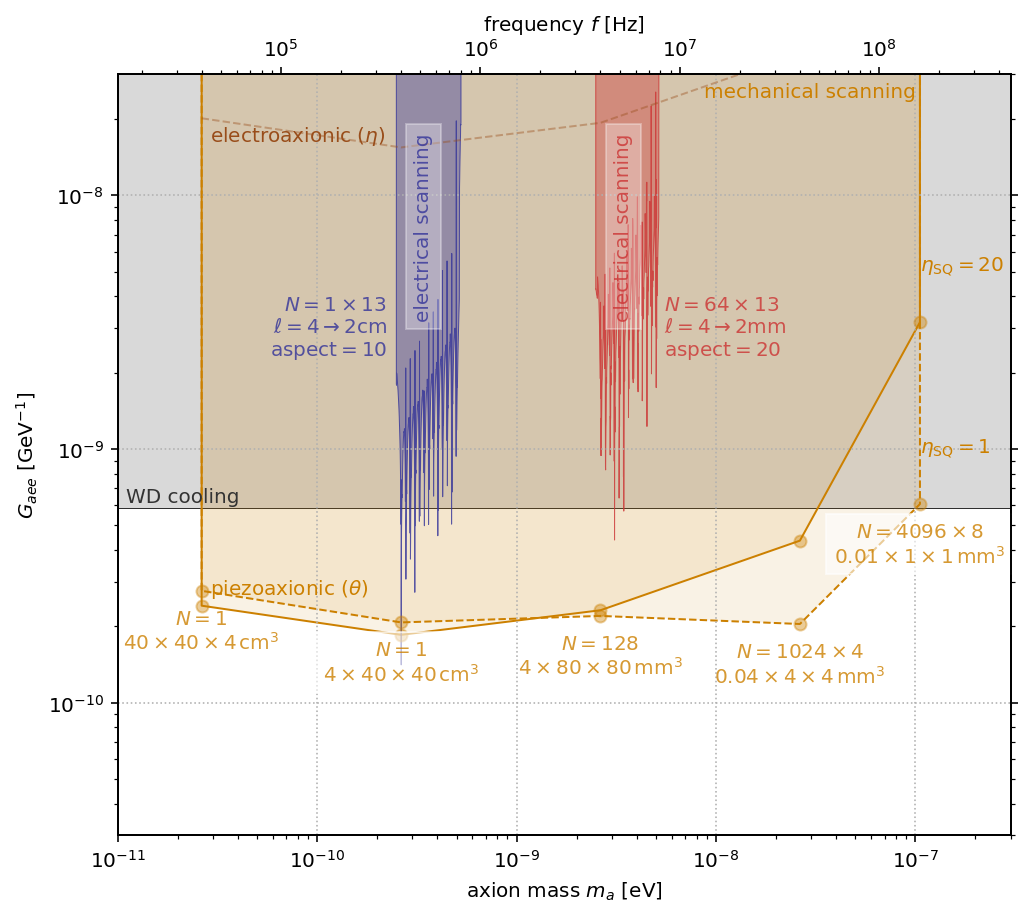

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlim(1e-11,3e-7); ax.set_ylim(3e-11,3e-8)
ax_top = ax.twiny();  ax_top.set_xlim(ax.get_xlim()); ax_top.set_xscale('log');
#ax_top2 = ax.twiny();  ax_top2.set_xlim(ax.get_xlim()); ax_top2.set_xscale('log');
#ax_top2.spines.top.set_position(("axes", 1.1))
ax_right = ax.twinx();  ax_right.set_ylim(ax.get_ylim()); ax_right.set_yscale('log');
ax_right.set_yticklabels([]);
ax.set_xlabel(r'axion mass $m_a~[\mathrm{eV}]$'); ax_top.set_xlabel('frequency $f~[\mathrm{Hz}]$'); ax.set_ylabel('$G_{aee}~[\mathrm{GeV}^{-1}]$')
ticks_left_minor = np.outer(10**(np.arange(-19.0,-5)),np.arange(1.,10.,1.)).flatten()
ticks_left_minor = ticks_left_minor[(ax.get_ylim()[0] < ticks_left_minor) & (ticks_left_minor < ax.get_ylim()[1])]
ticks_left_major = 10**(np.arange(-10.0,-7))
ticks_top_minor = np.outer(10**(np.arange(0.0,10)),np.arange(1.,10.,1.)).flatten() * Hz / eV; 
ticks_top_minor = ticks_top_minor[(ax_top.get_xlim()[0] < ticks_top_minor) & (ticks_top_minor < ax_top.get_xlim()[1])]
ticks_top_major = 10**(np.arange(5,9)) * Hz / eV
ax.set_yticks(ticks_left_minor,minor=True); ax.set_yticks(ticks_left_major); 
ax_top.set_xticks([],minor=True); ax_top.set_xticks(ticks_top_minor,minor=True); ax_top.set_xticklabels([],minor=True)
ax_top.set_xticks(ticks_top_major,minor=False); ax_top.set_xticklabels(['$10^5$','$10^6$','$10^7$','$10^8$'],minor=False);
ax.grid(ls='dotted')

ax.fill_between([1e-12,1e-6],3e-13/MElectron*GeV,1,edgecolor=(0,0,0,0.8),facecolor=(0,0,0,0.15),lw=0.5)

ax.fill_between(arr_sens_ultimate_q[:,0]/eV,arr_sens_ultimate_G_aee_q[:,1],1,
       ls='dashed',lw=1,facecolor=(0.8,0.5,0,0.1),edgecolor=(0.8,0.5,0,1))
ax.fill_between(arr_sens_ultimate[:,0]/eV,arr_sens_ultimate_G_aee[:,1],1,
       ls='solid',lw=1,facecolor=(0.8,0.5,0,0.1),edgecolor=(0.8,0.5,0,1))
ax.plot(arr_sens_ultimate[:,0]/eV,arr_sens_ultimate_G_aee[:,2],
       ls='dashed',lw=1,color=(0.6,0.3,0.1,0.4))
ax.plot(arr_sens_ultimate[:,0]/eV,arr_sens_ultimate_G_aee[:,1],
       ls='none',lw=0,color=(0.8,0.5,0,0.4),marker='.',markersize=12)
ax.plot(arr_sens_ultimate_q[:,0]/eV,arr_sens_ultimate_G_aee_q[:,1],
       ls='none',lw=0,color=(0.8,0.5,0,0.4),marker='.',markersize=12)

ax.fill_between(arr_comb_hypo_4cm_xylo[:,0]/eV,arr_comb_hypo_4cm_xylo_G_aee[:,1],1,
                lw=0.5,ls='solid',edgecolor=(0.2,0.2,0.6,0.8),facecolor=(0.2,0.2,0.6,0.4),label=r'$\mathrm{2cm - 4cm}$, $N = 1$, 10$\,$yr/octave');
ax.fill_between(arr_comb_hypo_4mm_xylo[:,0]/eV,arr_comb_hypo_4mm_xylo_G_aee[:,1],1,
                lw=0.5,ls='solid',edgecolor=(0.8,0.2,0.2,0.8),facecolor=(0.8,0.2,0.2,0.4),label=r'$\mathrm{2mm - 4mm}$, $N = 256$, 10$\,$yr/octave');
text_ultimate=[r'$N=1$'+'\n'+r'$40\times 40 \times 4 \, \mathrm{cm}^3$',r'$N=1$'+'\n'+r'$4\times 40 \times 40 \, \mathrm{cm}^3$',
               r'$N=128$'+'\n'+r'$4 \times 80 \times 80 \, \mathrm{mm}^3$',
               r'$N=1024 \times 4$'+'\n'+r'$0.04\times 4 \times 4 \, \mathrm{mm}^3$',
               r'$N=4096 \times 8$'+'\n'+r'$0.01\times 1 \times 1 \, \mathrm{mm}^3$'];
for i,m in enumerate(arr_sens_ultimate_G_aee_q[:,0]):
    if (i == 1) or (i == 4):
        ax.text(m/eV,0.85*arr_sens_ultimate_G_aee_q[i,1],text_ultimate[i],color=(0.8,0.5,0,0.8),fontsize=10,va='top',ha='center',backgroundcolor=(1,1,1,0.6))
    else:
        ax.text(m/eV,0.85*arr_sens_ultimate_G_aee_q[i,1],text_ultimate[i],color=(0.8,0.5,0,0.8),fontsize=10,va='top',ha='center',backgroundcolor=(1,1,1,0.0))
ax.text(2.9e-11,0.95*arr_sens_ultimate_G_aee[0,2],r'electroaxionic ($\eta$)',fontsize=10,color=(0.6,0.3,0.1,1),va='top',ha='left',rotation=0);
ax.text(2.9e-11,1.05*arr_sens_ultimate_G_aee[0,1],r'piezoaxionic ($\theta$)',fontsize=10,color=(0.8,0.5,0,1),va='bottom',ha='left',rotation=0)
ax.text(1.3*arr_sens_ultimate_G_aee[1,0]/eV,3.2e-9,'electrical scanning',color=(0.2,0.2,0.6,0.8),rotation=90,va='bottom',ha='center',backgroundcolor=(1,1,1,0.3))
ax.text(1.3*arr_sens_ultimate_G_aee[2,0]/eV,3.2e-9,'electrical scanning',color=(0.8,0.2,0.2,0.8),rotation=90,va='bottom',ha='center',backgroundcolor=(1,1,1,0.3))
ax.text(0.85*arr_sens_ultimate[1,0]/eV,3e-9,r'$N=1\times 13$'+'\n'+r'$\ell = \mathrm{4\rightarrow2 cm}$'+'\n'+r'$\mathrm{aspect} = 10$',color=(0.2,0.2,0.6,0.8),va='center',ha='right')
ax.text(2.075*arr_sens_ultimate[2,0]/eV,3e-9,r'$N=64\times 13$'+'\n'+r'$\ell = \mathrm{4\rightarrow2 mm}$'+'\n'+r'$\mathrm{aspect} = 20$',color=(0.8,0.2,0.2,0.8),va='center',ha='left')
ax.text(arr_sens_ultimate_G_aee[-1,0]/eV,1.5*arr_sens_ultimate_G_aee[-1,1],
        r'$\eta_\mathrm{SQ}=20$',fontsize=10,color=(0.8,0.5,0,1),va='bottom',ha='left',rotation=0)
ax.text(arr_sens_ultimate_G_aee[-1,0]/eV,1.5*arr_sens_ultimate_G_aee_q[-1,1],
        r'$\eta_\mathrm{SQ}=1$',fontsize=10,color=(0.8,0.5,0,1),va='bottom',ha='left',rotation=0)
ax.text(0.95*arr_sens_ultimate[-1,0]/eV,2.8e-8,'mechanical scanning',fontsize=10,color=(0.8,0.5,0,1),va='top',ha='right')
ax.text(1.1e-11,1.05*3e-13/MElectron*GeV,'WD cooling',color=(0.2,0.2,0.2),ha='left');

In [44]:
fig.savefig(dir_fig+'sensitivity_G_aee_eta20.pdf', bbox_inches='tight', pad_inches = 0)